## Description de projet
Vous êtes Data Scientist au sein d'une société financière, nommée "Prêt à dépenser", qui propose des crédits à la consommation pour des personnes ayant peu ou pas du tout d'historique de prêt.

L’entreprise souhaite développer un modèle de scoring de la probabilité de défaut de paiement du client pour étayer la décision d'accorder ou non un prêt à un client potentiel en s’appuyant sur des sources de données variées (données comportementales, données provenant d'autres institutions financières, etc.).

De plus, les chargés de relation client ont fait remonter le fait que les clients sont de plus en plus demandeurs de transparence vis-à-vis des décisions d’octroi de crédit. Cette demande de transparence des clients va tout à fait dans le sens des valeurs que l’entreprise veut incarner.

Elle décide donc de développer un dashboard interactif pour que les chargés de relation client puissent à la fois expliquer de façon la plus transparente possible les décisions d’octroi de crédit, mais également permettre à leurs clients de disposer de leurs informations personnelles et de les explorer facilement.

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
# Suppress warnings from pandas

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.neural_network import MLPClassifier
from sklearn import decomposition
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, f1_score
from sklearn.metrics import make_scorer, fbeta_score, precision_score, recall_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn import linear_model, neighbors
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV , train_test_split
import xgboost as xgb
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import sklearn.metrics as skm
import time
import functions as fc
import shap
from functions import *
import joblib
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_row', 500)

#### Import les datasets

In [4]:
df= pd.read_csv('Home_credit_risk_data_modeling.csv', index_col  = 0)
df = df.loc[:, ~df.columns.str.match('index')]
df.head()

,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
0,100002,1.0,0,0,0,0,202500.0,406597.5,24700.5,351000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100003,0.0,1,0,1,0,270000.0,1293502.5,35698.5,1129500.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100004,0.0,0,1,0,0,67500.0,135000.0,6750.0,135000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100006,0.0,1,0,0,0,135000.0,312682.5,29686.5,297000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
4,100007,0.0,0,0,0,0,121500.0,513000.0,21865.5,513000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df.shape

(356251, 797)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 356251 entries, 0 to 356254
Columns: 797 entries, SK_ID_CURR to CC_COUNT
dtypes: float64(622), int64(175)
memory usage: 2.1 GB


In [7]:
df.isna().sum()

SK_ID_CURR                               0
TARGET                               48744
CODE_GENDER                              0
FLAG_OWN_CAR                             0
FLAG_OWN_REALTY                          0
                                     ...  
CC_NAME_CONTRACT_STATUS_nan_MAX     252693
CC_NAME_CONTRACT_STATUS_nan_MEAN    252693
CC_NAME_CONTRACT_STATUS_nan_SUM     252693
CC_NAME_CONTRACT_STATUS_nan_VAR     253385
CC_COUNT                            252693
Length: 797, dtype: int64

In [8]:
np.isinf(df).values.sum()

21

On a constaté qu'il y a des valeurs infinite dans notre datasets, pour les corriger ;

In [9]:

# printing column name where infinity is present
print()
print("printing column name where infinity is present")
col_name = df.columns.to_series()[np.isinf(df).any()]
print(col_name)

# printing row index with infinity
print()
print("printing row index with infinity ")

r = df.index[np.isinf(df).any(1)]
print(r)


printing column name where infinity is present
PREV_APP_CREDIT_PERC_MAX          PREV_APP_CREDIT_PERC_MAX
REFUSED_APP_CREDIT_PERC_MAX    REFUSED_APP_CREDIT_PERC_MAX
INSTAL_PAYMENT_PERC_MAX            INSTAL_PAYMENT_PERC_MAX
dtype: object

printing row index with infinity 
Int64Index([5687, 60477, 79077, 89018, 98509, 126768, 128791, 140426, 152087, 167136, 199103, 201086, 236164, 238381, 272829, 277962, 287300, 292852, 305373, 310339], dtype='int64')


In [10]:

for i in df.columns :
    c = np.isinf(df[i]).values.sum()
    print(f" {df[i].name} contains " + str(c) + " infinite values")

 SK_ID_CURR contains 0 infinite values
 TARGET contains 0 infinite values
 CODE_GENDER contains 0 infinite values
 FLAG_OWN_CAR contains 0 infinite values
 FLAG_OWN_REALTY contains 0 infinite values
 CNT_CHILDREN contains 0 infinite values
 AMT_INCOME_TOTAL contains 0 infinite values
 AMT_CREDIT contains 0 infinite values
 AMT_ANNUITY contains 0 infinite values
 AMT_GOODS_PRICE contains 0 infinite values
 REGION_POPULATION_RELATIVE contains 0 infinite values
 DAYS_BIRTH contains 0 infinite values
 DAYS_EMPLOYED contains 0 infinite values
 DAYS_REGISTRATION contains 0 infinite values
 DAYS_ID_PUBLISH contains 0 infinite values
 OWN_CAR_AGE contains 0 infinite values
 FLAG_MOBIL contains 0 infinite values
 FLAG_EMP_PHONE contains 0 infinite values
 FLAG_WORK_PHONE contains 0 infinite values
 FLAG_CONT_MOBILE contains 0 infinite values
 FLAG_PHONE contains 0 infinite values
 FLAG_EMAIL contains 0 infinite values
 CNT_FAM_MEMBERS contains 0 infinite values
 REGION_RATING_CLIENT contains 0 

 PREV_AMT_GOODS_PRICE_MAX contains 0 infinite values
 PREV_AMT_GOODS_PRICE_MEAN contains 0 infinite values
 PREV_HOUR_APPR_PROCESS_START_MIN contains 0 infinite values
 PREV_HOUR_APPR_PROCESS_START_MAX contains 0 infinite values
 PREV_HOUR_APPR_PROCESS_START_MEAN contains 0 infinite values
 PREV_RATE_DOWN_PAYMENT_MIN contains 0 infinite values
 PREV_RATE_DOWN_PAYMENT_MAX contains 0 infinite values
 PREV_RATE_DOWN_PAYMENT_MEAN contains 0 infinite values
 PREV_DAYS_DECISION_MIN contains 0 infinite values
 PREV_DAYS_DECISION_MAX contains 0 infinite values
 PREV_DAYS_DECISION_MEAN contains 0 infinite values
 PREV_CNT_PAYMENT_MEAN contains 0 infinite values
 PREV_CNT_PAYMENT_SUM contains 0 infinite values
 PREV_NAME_CONTRACT_TYPE_Cash loans_MEAN contains 0 infinite values
 PREV_NAME_CONTRACT_TYPE_Consumer loans_MEAN contains 0 infinite values
 PREV_NAME_CONTRACT_TYPE_Revolving loans_MEAN contains 0 infinite values
 PREV_NAME_CONTRACT_TYPE_XNA_MEAN contains 0 infinite values
 PREV_NAME_CONTR

 CC_AMT_RECIVABLE_MAX contains 0 infinite values
 CC_AMT_RECIVABLE_MEAN contains 0 infinite values
 CC_AMT_RECIVABLE_SUM contains 0 infinite values
 CC_AMT_RECIVABLE_VAR contains 0 infinite values
 CC_AMT_TOTAL_RECEIVABLE_MIN contains 0 infinite values
 CC_AMT_TOTAL_RECEIVABLE_MAX contains 0 infinite values
 CC_AMT_TOTAL_RECEIVABLE_MEAN contains 0 infinite values
 CC_AMT_TOTAL_RECEIVABLE_SUM contains 0 infinite values
 CC_AMT_TOTAL_RECEIVABLE_VAR contains 0 infinite values
 CC_CNT_DRAWINGS_ATM_CURRENT_MIN contains 0 infinite values
 CC_CNT_DRAWINGS_ATM_CURRENT_MAX contains 0 infinite values
 CC_CNT_DRAWINGS_ATM_CURRENT_MEAN contains 0 infinite values
 CC_CNT_DRAWINGS_ATM_CURRENT_SUM contains 0 infinite values
 CC_CNT_DRAWINGS_ATM_CURRENT_VAR contains 0 infinite values
 CC_CNT_DRAWINGS_CURRENT_MIN contains 0 infinite values
 CC_CNT_DRAWINGS_CURRENT_MAX contains 0 infinite values
 CC_CNT_DRAWINGS_CURRENT_MEAN contains 0 infinite values
 CC_CNT_DRAWINGS_CURRENT_SUM contains 0 infinite val

In [11]:
df.replace([np.inf, -np.inf], np.nan, inplace = True)

In [12]:
r = df.index[np.isinf(df).any(1)]
print(r)

Int64Index([], dtype='int64')


On corrige les valeurs infinite, et maintenant il n'y a pas d'infinite

In [14]:
df.set_index('SK_ID_CURR', inplace = True)
df

,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100002,1.0,0,0,0,0,202500.0,406597.5,24700.5,351000.0,0.018801,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100003,0.0,1,0,1,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100004,0.0,0,1,0,0,67500.0,135000.0,6750.0,135000.0,0.010032,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100006,0.0,1,0,0,0,135000.0,312682.5,29686.5,297000.0,0.008019,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
100007,0.0,0,0,0,0,121500.0,513000.0,21865.5,513000.0,0.028663,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456221,NaN,1,0,0,0,121500.0,412560.0,17473.5,270000.0,0.002042,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
456222,NaN,1,0,1,2,157500.0,622413.0,31909.5,495000.0,0.035792,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
456223,NaN,1,1,0,1,202500.0,315000.0,33205.5,315000.0,0.026392,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


On separe la dataframe comme train et test, et puis on utilise Python garbage collections for diminuer la taille de dataframe

In [15]:
df_train_sample = df.loc[~(df['TARGET'].isnull())]
df_test_sample = df.loc[df['TARGET'].isnull()]
del df
gc.collect()

0

In [16]:
df_train_sample

,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100002,1.0,0,0,0,0,202500.0,406597.5,24700.5,351000.0,0.018801,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100003,0.0,1,0,1,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100004,0.0,0,1,0,0,67500.0,135000.0,6750.0,135000.0,0.010032,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100006,0.0,1,0,0,0,135000.0,312682.5,29686.5,297000.0,0.008019,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
100007,0.0,0,0,0,0,121500.0,513000.0,21865.5,513000.0,0.028663,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456251,0.0,0,0,1,0,157500.0,254700.0,27558.0,225000.0,0.032561,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
456252,0.0,1,0,0,0,72000.0,269550.0,12001.5,225000.0,0.025164,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
456253,0.0,1,0,0,0,153000.0,677664.0,29979.0,585000.0,0.005002,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
df_train_sample[df_train_sample['TARGET'] == 1].shape

(24825, 796)

il y a 307507 ligne dans notre dataset dont contains 24825 qui sont target = 1

In [18]:
X = df_train_sample.drop(columns = ['TARGET']).copy()
y = df_train_sample['TARGET'].copy()

Certains colonnes ont moins de 10 differents types de valeurs, on les evalue comme categorigal

In [19]:
def list_features_att(df):
    '''Function to attribute to columns of a dataframe a category into a several list
    it returns two lists.
    --> Numerical: num_list
    --> discrete_numerical: num_dis_list'''

    num_list = list()
    num_dis_list = list()
    for name in df.columns:
        if df[name].nunique() < 10:
            num_dis_list.append(name)
        else:
            num_list.append(name)
    return num_list, num_dis_list

L'imputation for les valeurs manquantes, ici, on utilise "mean" method

In [20]:
# Imputation in function of the numeric format
numerical_cont_list, numerical_disc_list = list_features_att(X)
time_init = time.time()
#imputation on numeric continue columns with 'mean' strategy
X[numerical_cont_list] = SimpleImputer(strategy='mean').fit_transform(X[numerical_cont_list]) # mean
#imputation on  discrete numeric columns with 'most_frequent' strategy
X[numerical_disc_list] = SimpleImputer(strategy='most_frequent').fit_transform(X[numerical_disc_list])
print (f'time for imputation: {time.time() - time_init:.2f}')

time for imputation: 338.52


0.0    14134
1.0     1241
Name: TARGET, dtype: int64


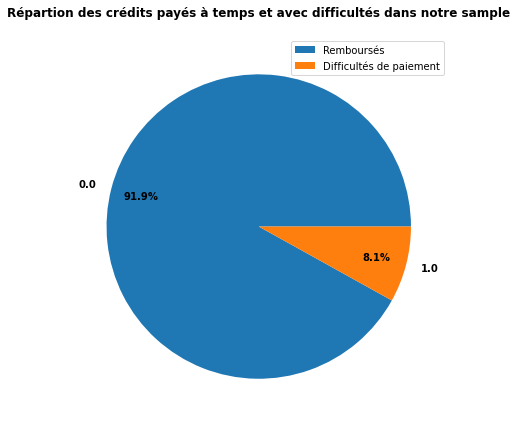

sample features shape:(15375, 795), sample target shape: (15375,)


In [21]:
# on ne garde que les trains result dans notre split, train_size est 0.05%
X1,_,y1,_ = train_test_split(X, y, train_size=0.05, stratify=y, random_state=42)
# verifie imbalanced data
figure1 = plt.figure(figsize=(10,7), facecolor='w')
plt.title('Répartion des crédits payés à temps et avec difficultés dans notre sample', fontweight='bold', pad=20)
plt.axis('off')
x = y1.value_counts()
print(x)

plt.pie(x, labels=[i for i in x.index], autopct="%.1f%%", pctdistance=0.8,
        textprops={'fontsize': 10, 'fontweight': 'bold'})
plt.legend(['Remboursés', 'Difficultés de paiement'])
plt.show()
print(f'sample features shape:{X1.shape}, sample target shape: {y1.shape}')

### Split et StandardScaler

On crée les nouvaux datasets comme test et test_normalisée. X1 et y1 qui sont venues "train_size=0.05"

In [22]:
time_init = time.time()
# data split
X1_train, X1_test_new, y1_train, y1_test = train_test_split(X1,y1, train_size=0.8, shuffle= True, stratify= y1, random_state= 42)
# Normalisation avec standardScaler
path = '/Users/ceyhun/OPENCLASSROOM/PROJET_7_2/Projet_File'
X1_test_new.to_csv(path+'/test_sample_data_home_risk.csv')
std_scaler = StandardScaler()
std_scaler.fit(X1_train)
joblib.dump(std_scaler, "std_scale_joblib.pkl")
X1_train = std_scaler.transform(X1_train)

X1_test = std_scaler.transform(X1_test_new)
y1_train.to_csv(path+'/y_train_sample_data_home_risk.csv')
y1_test.to_csv(path+'/y_test_sample_data_home_risk.csv')
# on crée une dataframe pour test sample
test_sample = pd.DataFrame(X1_test, columns = X1.columns, index = X1_test_new.index)
# On ajoute index pour trouver les client/ ID_loan
#test_sample.set_index(X1_test_new['SK_ID_CURR'], drop = True, inplace = True)
#test_sample.index.rename('index', inplace = True)
#test_sample.drop('SK_ID_CURR', axis = 1, inplace = True)
# envoyer test sample pour l'utiliser dans Dashboard
test_sample.to_csv(path+'/test_sample_data_home_risk_normalisée.csv')
print (f'Temps pour split et normalisation: {time.time() - time_init:.2f}')


Temps pour split et normalisation: 4.30


In [23]:
# on visualise test sample dataframe
test_sample

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,...,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
330832,0.715012,-0.724383,1.488518,2.199424,-1.052468,-0.717550,-0.362570,-0.735207,0.738053,0.456085,...,-0.122893,-0.013447,-0.011725,-0.013395,0.0,0.0,0.0,0.0,0.0,-0.001619
401750,0.715012,-0.724383,-0.671809,-0.575803,1.064620,0.381788,-0.186095,0.241584,0.738053,-1.381439,...,-0.122893,-0.196694,-0.133589,-0.267823,0.0,0.0,0.0,0.0,0.0,-1.058406
176157,0.715012,-0.724383,-0.671809,-0.575803,4.357866,1.424859,1.552170,1.462572,3.806833,0.582590,...,-0.122893,-0.013447,-0.011725,-0.013395,0.0,0.0,0.0,0.0,0.0,-0.001619
127869,0.715012,-0.724383,-0.671809,-0.575803,0.358924,0.194640,-0.492539,0.375892,0.417380,0.116448,...,-0.122893,-0.196694,-0.133589,-0.267823,0.0,0.0,0.0,0.0,0.0,-1.665641
324855,0.715012,-0.724383,1.488518,-0.575803,0.594156,-1.014211,-0.799600,-0.942775,3.806833,-0.530283,...,-0.122893,-0.013447,-0.011725,-0.013395,0.0,0.0,0.0,0.0,0.0,-0.001619
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401200,0.715012,-0.724383,-0.671809,-0.575803,2.005547,-0.160012,-0.233832,-0.210182,-0.136946,-0.719582,...,-0.122893,-0.196694,-0.133589,-0.267823,0.0,0.0,0.0,0.0,0.0,-0.616781
231113,-1.398578,-0.724383,-0.671809,-0.575803,0.358924,-1.170914,-0.890455,-1.113714,0.417380,-1.103679,...,-0.122893,-0.013447,-0.011725,-0.013395,0.0,0.0,0.0,0.0,0.0,-0.001619
305145,0.715012,-0.724383,-0.671809,-0.575803,-0.817236,-0.711998,-0.292657,-0.613109,-0.812617,0.150366,...,-0.122893,-0.013447,-0.011725,-0.013395,0.0,0.0,0.0,0.0,0.0,-0.001619


### Utiliser Dummy Classifier pour Baseline model

In [24]:
strategies = ['most_frequent', 'stratified', 'uniform', 'constant']

test_scores = []
train_scores = []
for s in strategies:
    if s =='constant':
        dclf = DummyClassifier(strategy = s, random_state = 42, constant =0)

    else:
        dclf = DummyClassifier(strategy = s, random_state = 42)
    start_time = time.time()    
    dclf.fit(X1_train, y1_train)
    train_time = time.time() - start_time
    score_test = dclf.score(X1_test, y1_test) # mean accuracy
    y_pred1 = dclf.predict(X1_test) # Perform classification
    y_pred_proba = dclf.predict_proba(X1_test)[:,1] # Perform classification
    test_scores.append({f'{s}': score_test})
    result = list()
    result.append({'model':'Dummy_Classifier', 'F1_score': f1_score(y1_test, y_pred1), 'Precision': precision_score(y1_test,y_pred1),
                   'Recall': recall_score(y1_test, y_pred1),'Accuracy': score_test,
                   'ROC AUC':roc_auc_score(y1_test, y_pred_proba), 
                   'Fbeta_Score' : fbeta_score(y1_test, y_pred1, beta=2),
                   'train_time': train_time,
                            })
result1 = pd.DataFrame(result)
print(result1)
print(test_scores)


              model  F1_score  Precision  Recall  Accuracy  ROC AUC  Fbeta_Score  train_time
0  Dummy_Classifier       0.0        0.0     0.0   0.91935      0.5          0.0     0.00044
[{'most_frequent': 0.9193495934959349}, {'stratified': 0.8523577235772358}, {'uniform': 0.5089430894308943}, {'constant': 0.9193495934959349}]


On trace les différents types de DummyClassifier strategies

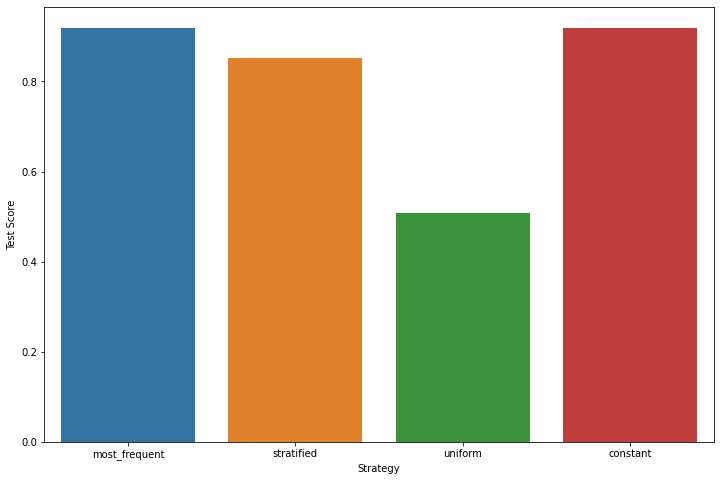

In [25]:
fig, ax1 = plt.subplots(1,1,figsize=(12,8) )
ax1 = sns.barplot(strategies, [k for i in test_scores for j,k in i.items()], ax = ax1);
ax1.set(xlabel ='Strategy', ylabel ='Test Score')

plt.show()

## SMOTE et RandomUnderSampler Methods sans GridSearch

On crée une model pipeline général sans GRIDSEARCHCV ou RANDOMIZEDGRIDSEARCHCV

In [26]:
# Classification - Model Pipeline
def modelPipeline(X_train, X_test, y_train, y_test, step1):
    rs = {'random_state': 42}
    log_reg = LogisticRegression(**rs)
    nb = BernoulliNB()
    knn = KNeighborsClassifier()
    svm = SVC(**rs,probability=True)
    mlp = MLPClassifier(max_iter=500, **rs)
    dt = DecisionTreeClassifier(**rs)
    rf = RandomForestClassifier(**rs)
    xgb = XGBClassifier(**rs, verbosity=0)
    lgbm = LGBMClassifier(**rs)

    clfs = [
            ('Logistic Regression', log_reg),
            ('Naive Bayes', nb),
            ('K-Nearest Neighbors', knn),
            ('SVM', svm),
            #('MLP', mlp),
            ('Decision Tree', dt),
            ('Random Forest', rf),
            ('XGBoost', xgb),
            ('LGBMClassifier', lgbm)
    ]
    if step1 == 'over' :
        Imb_Method = SMOTE(random_state=42)
    if step1 == 'under' :
        Imb_Method = RandomUnderSampler(random_state=42, sampling_strategy = 'majority')
        # avec sampling_strategy = majority, on diminue la dataset de 
    pipelines = []

    scores_df = pd.DataFrame(columns=['Model', 'F1_Score', 'Precision', 'Recall', 'Accuracy', 'ROC_AUC','fbeta_Score',\
                                      'train_time', 'Imbalanced_method'])


    for clf_name, clf in clfs:

        pipe = Pipeline(steps=[
                                   ('step1', Imb_Method),
                                   ('classifier', clf)
                                   ]
                            )
        start_time = time.time()
        pipe.fit(X_train, y_train)

        train_time = time.time() - start_time
        y_pred = pipe.predict(X_test)
        y_pred_proba = pipe.predict_proba(X_test)[:,1]
        # F1-Score
        fscore = skm.f1_score(y_test, y_pred)
        # Precision
        pres = skm.precision_score(y_test, y_pred)
        # Recall
        rcall = skm.recall_score(y_test, y_pred)
        # Accuracy
        accu = skm.accuracy_score(y_test, y_pred)
        # ROC_AUC
        roc_auc = skm.roc_auc_score(y_test, y_pred_proba)
        # fbeta_score
        fbeta = skm.fbeta_score(y_test, y_pred, average = 'binary', beta=2)


        pipelines.append(pipe)

        scores_df = scores_df.append({
                                      'Model' : clf_name,
                                      'F1_Score' : fscore,
                                      'Precision' : pres,
                                      'Recall' : rcall,
                                      'Accuracy' : accu,
                                      'ROC_AUC' : roc_auc,
                                      'fbeta_Score' : fbeta,
                                      'train_time': train_time,
                                      'Imbalanced_method' : Imb_Method

                                      },
                                     ignore_index=True)

    return pipelines, scores_df

In [27]:

# Pour SMOTE -> utilise "over"
_,scores_sans_gridsearch_SMOTE = modelPipeline(X1_train,X1_test,y1_train, y1_test, 'over')

In [28]:
scores_sans_gridsearch_SMOTE

,Model,F1_Score,Precision,Recall,Accuracy,ROC_AUC,fbeta_Score,train_time,Imbalanced_method
0,Logistic Regression,0.240458,0.1575,0.508065,0.741138,0.69182,0.351562,2.34017,SMOTE(random_state=42)
1,Naive Bayes,0.165946,0.105611,0.387097,0.686179,0.573972,0.252499,0.436792,SMOTE(random_state=42)
2,K-Nearest Neighbors,0.147627,0.08284,0.677419,0.369106,0.531131,0.278146,0.279821,SMOTE(random_state=42)
3,SVM,0.187793,0.224719,0.16129,0.88748,0.68036,0.17094,911.126425,SMOTE(random_state=42)
4,Decision Tree,0.149254,0.126761,0.181452,0.833171,0.535897,0.167038,6.590146,SMOTE(random_state=42)
5,Random Forest,0.015873,0.5,0.008065,0.91935,0.662661,0.01004,16.878275,SMOTE(random_state=42)
6,XGBoost,0.100719,0.466667,0.056452,0.918699,0.716545,0.068493,22.75346,SMOTE(random_state=42)
7,LGBMClassifier,0.081181,0.478261,0.044355,0.919024,0.737839,0.054187,4.588435,SMOTE(random_state=42)


On trace les classifier pour les compare par rapport aux ROC_AUC Scores

In [29]:
def classifier_compare(df_gr):
    df_gr.sort_values("ROC_AUC", inplace=True)
    ax = df_gr[["ROC_AUC","Precision","Recall", "Model"]].plot(kind="line", x="Model", figsize=(19,5), title="Classifier Performance Sorted by ROC_AUC")
    ax.legend()
    for p in ax.patches:
        ax.annotate( str( round(p.get_height(),3) ), (p.get_x() * 1.005, p.get_height() * 1.005))

    ax.title.set_size(20)
    plt.box(False)
    df_gr.sort_values("train_time", inplace=True)
    ax= df_gr[["train_time","Model"]].plot(kind="line", x="Model", figsize=(19,5), grid=True, title="Classifier Training Time (seconds)")
    ax.title.set_size(20)
    ax.legend(["Train Time"])
    plt.box(False)



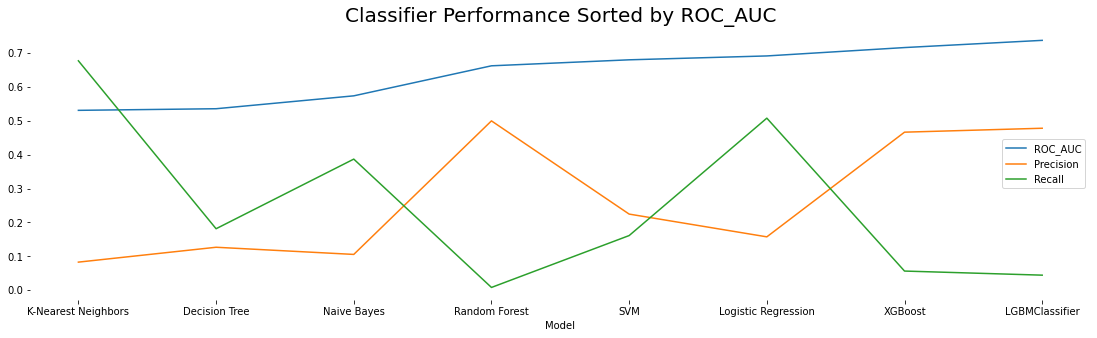

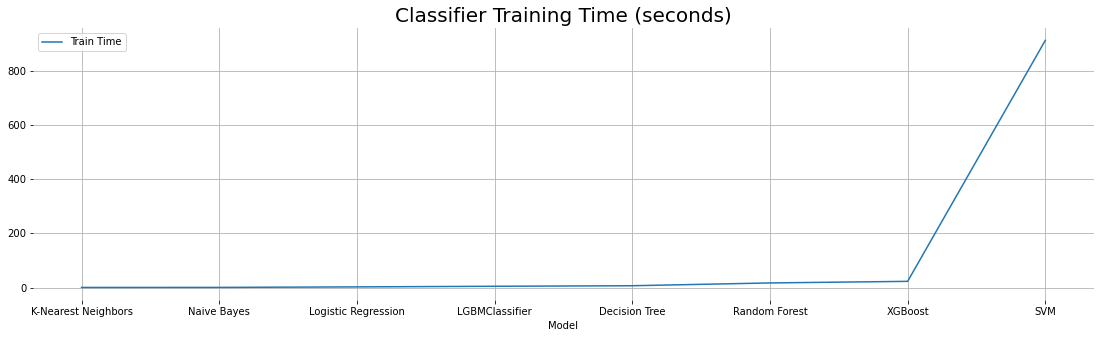

In [30]:
classifier_compare(scores_sans_gridsearch_SMOTE)

XGBOOST et LGBMClassifier nous returnent les meilleurs ROC_AUC Score

## RUS (RANDOM UNDER SAMPLER)

In [31]:
_,scores_sans_gridsearch_RUS= modelPipeline(X1_train,X1_test,y1_train, y1_test, 'under')

In [32]:
scores_sans_gridsearch_RUS

,Model,F1_Score,Precision,Recall,Accuracy,ROC_AUC,fbeta_Score,train_time,Imbalanced_method
0,Logistic Regression,0.235129,0.142252,0.677419,0.644553,0.691484,0.386562,0.070747,"RandomUnderSampler(random_state=42, sampling_strategy='majority')"
1,Naive Bayes,0.184573,0.111296,0.540323,0.614959,0.595901,0.3051,0.042889,"RandomUnderSampler(random_state=42, sampling_strategy='majority')"
2,K-Nearest Neighbors,0.158496,0.095085,0.475806,0.59252,0.54909,0.264219,0.017619,"RandomUnderSampler(random_state=42, sampling_strategy='majority')"
3,SVM,0.233927,0.144775,0.608871,0.678374,0.721575,0.371007,4.595949,"RandomUnderSampler(random_state=42, sampling_strategy='majority')"
4,Decision Tree,0.186503,0.109986,0.612903,0.56878,0.588907,0.320135,0.391218,"RandomUnderSampler(random_state=42, sampling_strategy='majority')"
5,Random Forest,0.244364,0.149068,0.677419,0.662114,0.718367,0.396413,0.926195,"RandomUnderSampler(random_state=42, sampling_strategy='majority')"
6,XGBoost,0.249645,0.151463,0.709677,0.655935,0.739185,0.408542,1.766282,"RandomUnderSampler(random_state=42, sampling_strategy='majority')"
7,LGBMClassifier,0.236939,0.144914,0.649194,0.662764,0.728768,0.382786,1.249327,"RandomUnderSampler(random_state=42, sampling_strategy='majority')"


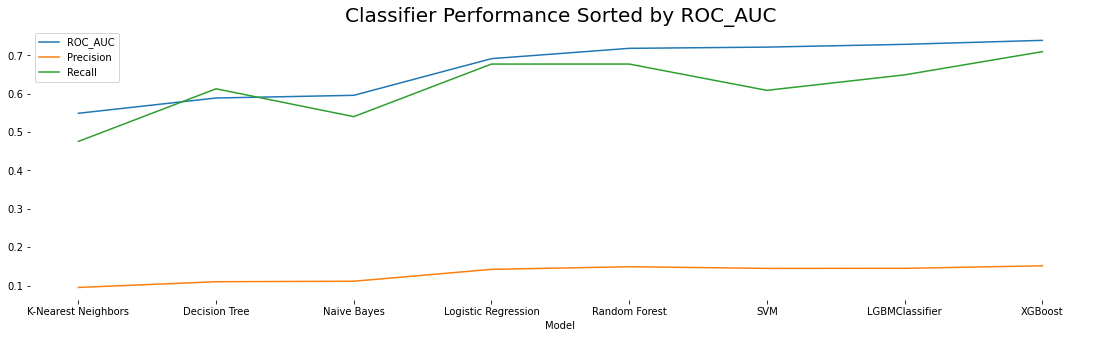

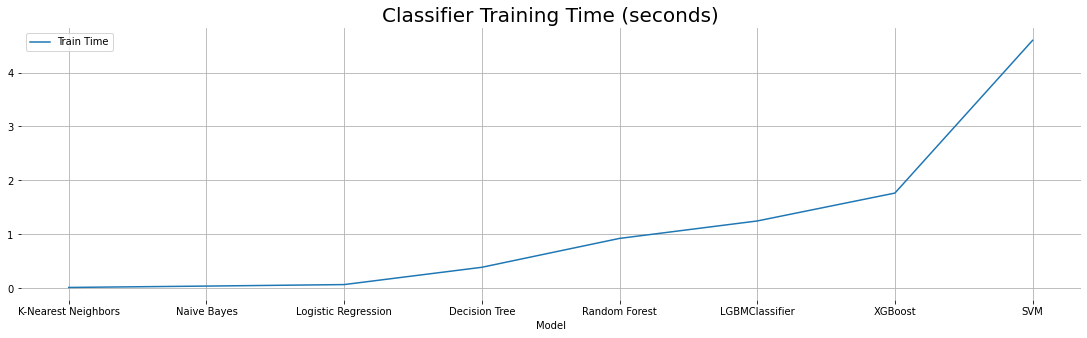

In [33]:
classifier_compare(scores_sans_gridsearch_RUS)

Pour RUS -> XGBOOST nous retorun le meilleur ROC_AUC Score

On cumule SMOTE et RUS dans une dataframe

In [34]:
df_scores_sans_GS = scores_sans_gridsearch_SMOTE.append(scores_sans_gridsearch_RUS, ignore_index = True)
df_scores_sans_GS

,Model,F1_Score,Precision,Recall,Accuracy,ROC_AUC,fbeta_Score,train_time,Imbalanced_method
0,K-Nearest Neighbors,0.147627,0.08284,0.677419,0.369106,0.531131,0.278146,0.279821,SMOTE(random_state=42)
1,Naive Bayes,0.165946,0.105611,0.387097,0.686179,0.573972,0.252499,0.436792,SMOTE(random_state=42)
2,Logistic Regression,0.240458,0.1575,0.508065,0.741138,0.69182,0.351562,2.34017,SMOTE(random_state=42)
3,LGBMClassifier,0.081181,0.478261,0.044355,0.919024,0.737839,0.054187,4.588435,SMOTE(random_state=42)
4,Decision Tree,0.149254,0.126761,0.181452,0.833171,0.535897,0.167038,6.590146,SMOTE(random_state=42)
5,Random Forest,0.015873,0.5,0.008065,0.91935,0.662661,0.01004,16.878275,SMOTE(random_state=42)
6,XGBoost,0.100719,0.466667,0.056452,0.918699,0.716545,0.068493,22.75346,SMOTE(random_state=42)
7,SVM,0.187793,0.224719,0.16129,0.88748,0.68036,0.17094,911.126425,SMOTE(random_state=42)
8,K-Nearest Neighbors,0.158496,0.095085,0.475806,0.59252,0.54909,0.264219,0.017619,"RandomUnderSampler(random_state=42, sampling_strategy='majority')"
9,Naive Bayes,0.184573,0.111296,0.540323,0.614959,0.595901,0.3051,0.042889,"RandomUnderSampler(random_state=42, sampling_strategy='majority')"


Meilleur fbeta score est XGBOOST, le score F-beta est la moyenne harmonique pondérée de la précision et du rappel. On essaie de diminuer les FN pour notre model.



### GRIDSEARCHCV pour les Models

On crée differents types de model et params pour gridsearchcv

In [35]:

def modelPipelineGrid(X_train, X_test, y_train, y_test, step1):
    scores_Cv = []
    rs = {'random_state': 42}
    log_reg = LogisticRegression(**rs)
    nb = BernoulliNB()
    knn = KNeighborsClassifier()
    svm = SVC(**rs)
    mlp = MLPClassifier(max_iter=500, **rs)
    dt = DecisionTreeClassifier(**rs)
    rf = RandomForestClassifier(**rs)
    xgb = XGBClassifier(**rs, verbosity=0)
    lgbm = LGBMClassifier(**rs)

    xgb_params = {'n_estimators':range(5,50,5), 'max_depth': [5, 7, 10], 'learning_rate':[0.1, 0.5]}

    log_reg_params = {'C': [0.1, 3, 50]}

    knn_params = {'n_neighbors':range(2,200,2)}

    random_params = {'n_estimators':range(5,50,5), 'max_depth': [5, 7, 10]}

    lgbm_params = {'n_estimators':range(5,50,5), 'max_depth': [5, 7, 10], 'learning_rate':[0.1, 0.5]}

    dt_params = {'criterion' : ['gini', 'entropy'],  'max_depth' : [2,4,6,8,10]}



    clfs = [
            ('Logistic Regression', log_reg,log_reg_params),
            ('K-Nearest Neighbors', knn,knn_params),
            ('Decision Tree', dt,dt_params),
            ('Random Forest', rf,random_params),
            ('XGBoost', xgb,xgb_params),
            ('LGBMClassifier', lgbm,lgbm_params)
            ]
    if step1 == 'over' :
        Imb_Method = SMOTE(random_state=42)
    if step1 == 'under' :
        Imb_Method = RandomUnderSampler(random_state=42, sampling_strategy = 'majority')
    for clf_name, clf, param_grid in clfs:

        pipe = Pipeline(steps=[
                                   ('step1', Imb_Method),
                                   ('classifier', clf)
                                   ]
                            )

        search = GridSearchCV(pipe, {f'classifier__{paramname}': paramvalue for paramname, paramvalue in param_grid.items()},cv = 5, scoring='roc_auc')
        search.fit(X_train, y_train)
        scores_Cv.append({'model':clf_name, 'best_score ROC_AUC':search.best_score_, 'best parameters':search.best_params_,
                          'Best model':search.best_estimator_,'Refit Time(s)':search.refit_time_, 'Comment':f'{Imb_Method} train data'})

    return scores_Cv


Pour imbalanced technique SMOTE :

In [36]:
ScoresGridSearch_SMOTE = modelPipelineGrid(X1_train, X1_test, y1_train, y1_test, 'over')
ScoresGridSearch_SMOTE

[{'model': 'Logistic Regression',
  'best_score ROC_AUC': 0.6863083787017269,
  'best parameters': {'classifier__C': 0.1},
  'Best model': Pipeline(steps=[('step1', SMOTE(random_state=42)),
                  ('classifier', LogisticRegression(C=0.1, random_state=42))]),
  'Refit Time(s)': 1.9419691562652588,
  'Comment': 'SMOTE(random_state=42) train data'},
 {'model': 'K-Nearest Neighbors',
  'best_score ROC_AUC': 0.6006858698303539,
  'best parameters': {'classifier__n_neighbors': 184},
  'Best model': Pipeline(steps=[('step1', SMOTE(random_state=42)),
                  ('classifier', KNeighborsClassifier(n_neighbors=184))]),
  'Refit Time(s)': 0.3887979984283447,
  'Comment': 'SMOTE(random_state=42) train data'},
 {'model': 'Decision Tree',
  'best_score ROC_AUC': 0.6315246973357505,
  'best parameters': {'classifier__criterion': 'entropy',
   'classifier__max_depth': 6},
  'Best model': Pipeline(steps=[('step1', SMOTE(random_state=42)),
                  ('classifier',
             

In [37]:
df_scores_GS_SMOTE = pd.DataFrame(ScoresGridSearch_SMOTE)
df_scores_GS_SMOTE

,model,best_score ROC_AUC,best parameters,Best model,Refit Time(s),Comment
0,Logistic Regression,0.686308,{'classifier__C': 0.1},"(SMOTE(random_state=42), LogisticRegression(C=0.1, random_state=42))",1.941969,SMOTE(random_state=42) train data
1,K-Nearest Neighbors,0.600686,{'classifier__n_neighbors': 184},"(SMOTE(random_state=42), KNeighborsClassifier(n_neighbors=184))",0.388798,SMOTE(random_state=42) train data
2,Decision Tree,0.631525,"{'classifier__criterion': 'entropy', 'classifier__max_depth': 6}","(SMOTE(random_state=42), DecisionTreeClassifier(criterion='entropy', max_depth=6, random_state=42))",3.769756,SMOTE(random_state=42) train data
3,Random Forest,0.683012,"{'classifier__max_depth': 10, 'classifier__n_estimators': 45}","(SMOTE(random_state=42), (DecisionTreeClassifier(max_depth=10, max_features='sqrt',\n random_state=1608637542), DecisionTreeClassifier(max_depth=10, max_features='sqrt',\n random_state=1273642419), DecisionTreeClassifier(max_depth=10, max_features='sqrt',\n random_state=1935803228), DecisionTreeClassifier(max_depth=10, max_features='sqrt',\n random_state=787846414), DecisionTreeClassifier(max_depth=10, ma...",5.901054,SMOTE(random_state=42) train data
4,XGBoost,0.724665,"{'classifier__learning_rate': 0.1, 'classifier__max_depth': 10, 'classifier__n_estimators': 45}","(SMOTE(random_state=42), XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,\n colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,\n early_stopping_rounds=None, enable_categorical=False,\n eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',\n importance_type=None, interaction_constraints='',\n learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,\n max_delta_step=0, max_depth=10, max_...",23.052927,SMOTE(random_state=42) train data
5,LGBMClassifier,0.731775,"{'classifier__learning_rate': 0.1, 'classifier__max_depth': 10, 'classifier__n_estimators': 45}","(SMOTE(random_state=42), LGBMClassifier(max_depth=10, n_estimators=45, random_state=42))",4.053316,SMOTE(random_state=42) train data


## RUS pour GridSearchCV

Pour imbalanced technique RUS :

In [38]:
ScoresGridSearch_RUS = modelPipelineGrid(X1_train, X1_test, y1_train, y1_test, 'under')

In [39]:
df_scores_GS_RUS = pd.DataFrame(ScoresGridSearch_RUS)

In [40]:
df_scores_GS = df_scores_GS_SMOTE.append(df_scores_GS_RUS, ignore_index=True)

In [41]:
df_scores_GS

,model,best_score ROC_AUC,best parameters,Best model,Refit Time(s),Comment
0,Logistic Regression,0.686308,{'classifier__C': 0.1},"(SMOTE(random_state=42), LogisticRegression(C=0.1, random_state=42))",1.941969,SMOTE(random_state=42) train data
1,K-Nearest Neighbors,0.600686,{'classifier__n_neighbors': 184},"(SMOTE(random_state=42), KNeighborsClassifier(n_neighbors=184))",0.388798,SMOTE(random_state=42) train data
2,Decision Tree,0.631525,"{'classifier__criterion': 'entropy', 'classifier__max_depth': 6}","(SMOTE(random_state=42), DecisionTreeClassifier(criterion='entropy', max_depth=6, random_state=42))",3.769756,SMOTE(random_state=42) train data
3,Random Forest,0.683012,"{'classifier__max_depth': 10, 'classifier__n_estimators': 45}","(SMOTE(random_state=42), (DecisionTreeClassifier(max_depth=10, max_features='sqrt',\n random_state=1608637542), DecisionTreeClassifier(max_depth=10, max_features='sqrt',\n random_state=1273642419), DecisionTreeClassifier(max_depth=10, max_features='sqrt',\n random_state=1935803228), DecisionTreeClassifier(max_depth=10, max_features='sqrt',\n random_state=787846414), DecisionTreeClassifier(max_depth=10, ma...",5.901054,SMOTE(random_state=42) train data
4,XGBoost,0.724665,"{'classifier__learning_rate': 0.1, 'classifier__max_depth': 10, 'classifier__n_estimators': 45}","(SMOTE(random_state=42), XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,\n colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,\n early_stopping_rounds=None, enable_categorical=False,\n eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',\n importance_type=None, interaction_constraints='',\n learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,\n max_delta_step=0, max_depth=10, max_...",23.052927,SMOTE(random_state=42) train data
5,LGBMClassifier,0.731775,"{'classifier__learning_rate': 0.1, 'classifier__max_depth': 10, 'classifier__n_estimators': 45}","(SMOTE(random_state=42), LGBMClassifier(max_depth=10, n_estimators=45, random_state=42))",4.053316,SMOTE(random_state=42) train data
6,Logistic Regression,0.690833,{'classifier__C': 0.1},"(RandomUnderSampler(random_state=42, sampling_strategy='majority'), LogisticRegression(C=0.1, random_state=42))",0.100953,"RandomUnderSampler(random_state=42, sampling_strategy='majority') train data"
7,K-Nearest Neighbors,0.681287,{'classifier__n_neighbors': 198},"(RandomUnderSampler(random_state=42, sampling_strategy='majority'), KNeighborsClassifier(n_neighbors=198))",0.027907,"RandomUnderSampler(random_state=42, sampling_strategy='majority') train data"
8,Decision Tree,0.659058,"{'classifier__criterion': 'entropy', 'classifier__max_depth': 4}","(RandomUnderSampler(random_state=42, sampling_strategy='majority'), DecisionTreeClassifier(criterion='entropy', max_depth=4, random_state=42))",0.222661,"RandomUnderSampler(random_state=42, sampling_strategy='majority') train data"
9,Random Forest,0.708783,"{'classifier__max_depth': 7, 'classifier__n_estimators': 45}","(RandomUnderSampler(random_state=42, sampling_strategy='majority'), (DecisionTreeClassifier(max_depth=7, max_features='sqrt',\n random_state=1608637542), DecisionTreeClassifier(max_depth=7, max_features='sqrt',\n random_state=1273642419), DecisionTreeClassifier(max_depth=7, max_features='sqrt',\n random_state=1935803228), DecisionTreeClassifier(max_depth=7, max_features='sqrt', random_state=787846414), DecisionTreeClassifier(m...",0.294798,"RandomUnderSampler(random_state=42, sampling_strategy='majority') train data"


## Utiliser Class Weight pour Imbalanced Data

In [42]:

def modelPipelineRandomizedClassWeight(X_train, X_test, y_train, y_test):
    scores_Cv_Cw = []
    rs = {'random_state': 42}
    log_reg = LogisticRegression(**rs)
    xgb = XGBClassifier(**rs, verbosity=0)
    lgbm = LGBMClassifier(**rs)
    
    weights = [1, 10, 25, 50, 75, 100]
    xgb_params = {'n_estimators':range(5,50,5), 'max_depth': [5, 7, 10], 'learning_rate':[0.1, 0.5],'scale_pos_weight':weights}
    balance = [{0:1, 1:3}, {0:1, 1:4}, {0:1, 1:5}, {0:1, 1:10}, {0:3, 1:10}]
    log_reg_params = {'C': [0.1, 3, 50], 'class_weight': balance}

    lgbm_params = {'n_estimators':range(5,70,5), 'max_depth': [5, 7, 10], 'learning_rate':[0.1, 0.5], 'class_weight': balance}


    clfs = [
            ('Logistic Regression', log_reg,log_reg_params),
            ('XGBoost', xgb,xgb_params),
            ('LGBMClassifier', lgbm,lgbm_params)
            ]
    
    for clf_name, clf, param_grid in clfs:

        pipe = Pipeline(steps=[
                                   ('classifier', clf)
                                   ]
                            )

        search = RandomizedSearchCV(pipe, {f'classifier__{paramname}': paramvalue for paramname, paramvalue in param_grid.items()},cv = 5, scoring='roc_auc')
        search.fit(X_train, y_train)
        scores_Cv_Cw.append({'model':clf_name, 'best_score ROC_AUC':search.best_score_, 'best parameters':search.best_params_,
                             'Best model':search.best_estimator_,'Refit Time(s)':search.refit_time_, 'Comment':'Class_weight Randomized train data'})

    return scores_Cv_Cw

Pour class weight, on utilise la methode RandomizedSearchCV

In [43]:
Cw_Scores_randomized = modelPipelineRandomizedClassWeight(X1_train, X1_test, y1_train, y1_test)
Cw_Scores_randomized 

[{'model': 'Logistic Regression',
  'best_score ROC_AUC': 0.7003484374656452,
  'best parameters': {'classifier__class_weight': {0: 1, 1: 3},
   'classifier__C': 0.1},
  'Best model': Pipeline(steps=[('classifier',
                   LogisticRegression(C=0.1, class_weight={0: 1, 1: 3},
                                      random_state=42))]),
  'Refit Time(s)': 0.9548718929290771,
  'Comment': 'Class_weight Randomized train data'},
 {'model': 'XGBoost',
  'best_score ROC_AUC': 0.7348027655607512,
  'best parameters': {'classifier__scale_pos_weight': 1,
   'classifier__n_estimators': 35,
   'classifier__max_depth': 5,
   'classifier__learning_rate': 0.1},
  'Best model': Pipeline(steps=[('classifier',
                   XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
                                 colsample_bylevel=1, colsample_bynode=1,
                                 colsample_bytree=1, early_stopping_rounds=None,
                                 enable_categorical

In [44]:
df_scores_Cw_Scores_randomized = pd.DataFrame(Cw_Scores_randomized)

In [45]:
df_scores_Cw_Scores_randomized

,model,best_score ROC_AUC,best parameters,Best model,Refit Time(s),Comment
0,Logistic Regression,0.700348,"{'classifier__class_weight': {0: 1, 1: 3}, 'classifier__C': 0.1}","(LogisticRegression(C=0.1, class_weight={0: 1, 1: 3}, random_state=42))",0.954872,Class_weight Randomized train data
1,XGBoost,0.734803,"{'classifier__scale_pos_weight': 1, 'classifier__n_estimators': 35, 'classifier__max_depth': 5, 'classifier__learning_rate': 0.1}","(XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,\n colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,\n early_stopping_rounds=None, enable_categorical=False,\n eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',\n importance_type=None, interaction_constraints='',\n learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,\n max_delta_step=0, max_depth=5, max_leaves=0, min_child_weigh...",7.265322,Class_weight Randomized train data
2,LGBMClassifier,0.738365,"{'classifier__n_estimators': 50, 'classifier__max_depth': 10, 'classifier__learning_rate': 0.1, 'classifier__class_weight': {0: 1, 1: 3}}","(LGBMClassifier(class_weight={0: 1, 1: 3}, max_depth=10, n_estimators=50,\n random_state=42))",1.637445,Class_weight Randomized train data


On cumule les dataframes qui se sont produit par SOMTE, RUS et class weight

In [46]:
df_scores_GS = df_scores_GS.append(Cw_Scores_randomized , ignore_index=True)
df_scores_GS = df_scores_GS.sort_values(by = 'best_score ROC_AUC', ascending = False, ignore_index=True)
df_scores_GS

,model,best_score ROC_AUC,best parameters,Best model,Refit Time(s),Comment
0,LGBMClassifier,0.740715,"{'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__n_estimators': 45}","(RandomUnderSampler(random_state=42, sampling_strategy='majority'), LGBMClassifier(max_depth=5, n_estimators=45, random_state=42))",0.637016,"RandomUnderSampler(random_state=42, sampling_strategy='majority') train data"
1,LGBMClassifier,0.738365,"{'classifier__n_estimators': 50, 'classifier__max_depth': 10, 'classifier__learning_rate': 0.1, 'classifier__class_weight': {0: 1, 1: 3}}","(LGBMClassifier(class_weight={0: 1, 1: 3}, max_depth=10, n_estimators=50,\n random_state=42))",1.637445,Class_weight Randomized train data
2,XGBoost,0.735824,"{'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__n_estimators': 45}","(RandomUnderSampler(random_state=42, sampling_strategy='majority'), XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,\n colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,\n early_stopping_rounds=None, enable_categorical=False,\n eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',\n importance_type=None, interaction_constraints='',\n learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,\n ...",1.403097,"RandomUnderSampler(random_state=42, sampling_strategy='majority') train data"
3,XGBoost,0.734803,"{'classifier__scale_pos_weight': 1, 'classifier__n_estimators': 35, 'classifier__max_depth': 5, 'classifier__learning_rate': 0.1}","(XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,\n colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,\n early_stopping_rounds=None, enable_categorical=False,\n eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',\n importance_type=None, interaction_constraints='',\n learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,\n max_delta_step=0, max_depth=5, max_leaves=0, min_child_weigh...",7.265322,Class_weight Randomized train data
4,LGBMClassifier,0.731775,"{'classifier__learning_rate': 0.1, 'classifier__max_depth': 10, 'classifier__n_estimators': 45}","(SMOTE(random_state=42), LGBMClassifier(max_depth=10, n_estimators=45, random_state=42))",4.053316,SMOTE(random_state=42) train data
5,XGBoost,0.724665,"{'classifier__learning_rate': 0.1, 'classifier__max_depth': 10, 'classifier__n_estimators': 45}","(SMOTE(random_state=42), XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,\n colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,\n early_stopping_rounds=None, enable_categorical=False,\n eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',\n importance_type=None, interaction_constraints='',\n learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,\n max_delta_step=0, max_depth=10, max_...",23.052927,SMOTE(random_state=42) train data
6,Random Forest,0.708783,"{'classifier__max_depth': 7, 'classifier__n_estimators': 45}","(RandomUnderSampler(random_state=42, sampling_strategy='majority'), (DecisionTreeClassifier(max_depth=7, max_features='sqrt',\n random_state=1608637542), DecisionTreeClassifier(max_depth=7, max_features='sqrt',\n random_state=1273642419), DecisionTreeClassifier(max_depth=7, max_features='sqrt',\n random_state=1935803228), DecisionTreeClassifier(max_depth=7, max_features='sqrt', random_state=787846414), DecisionTreeClassifier(m...",0.294798,"RandomUnderSampler(random_state=42, sampling_strategy='majority') train data"
7,Logistic Regression,0.700348,"{'classifier__class_weight': {0: 1, 1: 3}, 'classifier__C': 0.1}","(LogisticRegression(C=0.1, class_weight={0: 1, 1: 3}, random_state=42))",0.954872,Class_weight Randomized train data
8,Logistic Regression,0.690833,{'classifier__C': 0.1},"(RandomUnderSampler(random_state=42, sampling_strategy='majority'), LogisticRegression(C=0.1, random_state=42))",0.100953,"RandomUnderSampler(random_state=42, sampling_strategy='majority') train data"
9,Logistic Regression,0.686308,{'classifier__C': 0.1},"(SMOTE(random_state=42), LogisticRegres

### Utilisation de GridSearchCV Parameters

In [47]:
df_scores_avec_GS = pd.DataFrame()
y_pred_prob_list = list()
for i in df_scores_GS.index:
    model = df_scores_GS.iloc[i, 3]
    time_init = time.time()
    time_1 = time.time()
    y_model_pred = model.predict(X1_test)
    time_2 = time.time()
    y_model_pred_prob = model.predict_proba(X1_test)[:,1]
    result3= []
    result3.append({'model': df_scores_GS.iloc[i, 0], 'F1_score': f1_score(y1_test, y_model_pred ), 
                    'Precision': precision_score(y1_test,y_model_pred ), 'Recall': recall_score(y1_test, y_model_pred ),
                    'Accuracy': skm.accuracy_score(y1_test, y_model_pred), 'ROC_AUC':roc_auc_score(y1_test, y_model_pred_prob),
                    'fbeta_Score' : skm.fbeta_score(y1_test, y_model_pred, average = 'binary', beta=2),
                    'Train Time(s)':df_scores_GS.iloc[i, 4], 'Predict Time(s)': time_2 - time_1, 'Comment':f'{df_scores_GS.iloc[i, 5]}'})
    df_scores_avec_GS = df_scores_avec_GS.append(result3, ignore_index=True)
    y_pred_prob_list.append((y_model_pred_prob, df_scores_GS.iloc[i, 5]))
df_scores_avec_GS  
    

,model,F1_score,Precision,Recall,Accuracy,ROC_AUC,fbeta_Score,Train Time(s),Predict Time(s),Comment
0,LGBMClassifier,0.244396,0.148899,0.681452,0.660163,0.745953,0.397273,0.637016,0.062132,"RandomUnderSampler(random_state=42, sampling_strategy='majority') train data"
1,LGBMClassifier,0.165138,0.341772,0.108871,0.911220,0.743871,0.126050,1.637445,0.014093,Class_weight Randomized train data
2,XGBoost,0.252015,0.153984,0.693548,0.667967,0.745001,0.407776,1.403097,0.019553,"RandomUnderSampler(random_state=42, sampling_strategy='majority') train data"
3,XGBoost,0.008000,0.500000,0.004032,0.919350,0.743088,0.005030,7.265322,0.017804,Class_weight Randomized train data
4,LGBMClassifier,0.067416,0.473684,0.036290,0.919024,0.722415,0.044510,4.053316,0.013925,SMOTE(random_state=42) train data
5,XGBoost,0.030769,0.333333,0.016129,0.918049,0.715145,0.019920,23.052927,0.027315,SMOTE(random_state=42) train data
6,Random Forest,0.237846,0.146006,0.641129,0.668618,0.715535,0.382028,0.294798,0.034828,"RandomUnderSampler(random_state=42, sampling_strategy='majority') train data"
7,Logistic Regression,0.251521,0.253061,0.250000,0.880000,0.716166,0.250606,0.954872,0.003483,Class_weight Randomized train data
8,Logistic Regression,0.228856,0.138913,0.649194,0.647154,0.698175,0.374245,0.100953,0.002738,"RandomUnderSampler(random_state=42, sampling_strategy='majority') train data"
9,Logistic Regression,0.244782,0.160050,0.520161,0.741138,0.692741,0.358732,1.941969,0.002532,SMOTE(random_state=42) train data


Par rapport aux fbeta_score, le meilleur scores sont LGBMClassifier avec GridSearchCV

## RandomizedSearchCV

On augmente et change la distance des params et recalcule les modules

In [48]:

def modelPipelineRandom(X_train, X_test, y_train, y_test, step1):
    scores_Cv_random = []
    rs = {'random_state': 42}
    log_reg = LogisticRegression(**rs)
    nb = BernoulliNB()
    knn = KNeighborsClassifier()
    svm = SVC(**rs)
    mlp = MLPClassifier(max_iter=500, **rs)
    dt = DecisionTreeClassifier(**rs)
    rf = RandomForestClassifier(**rs)
    xgb = XGBClassifier(**rs, verbosity=0)
    lgbm = LGBMClassifier(**rs)

    xgb_params = {'n_estimators':range(5,100,5), 'max_depth': [5, 7, 10], 'learning_rate':[0.1, 0.2, 0.5]}

    log_reg_params = {'C': [0.1, 5, 100]}

    knn_params = {'n_neighbors':range(2,300,2)}

    random_params = {'n_estimators':range(5,100,5), 'max_depth': [5, 7, 10, 20]}

    lgbm_params = {'n_estimators':range(5,100,5), 'max_depth': [5, 7, 10, 20], 'learning_rate':[0.1, 0.2, 0.5]}

    dt_params = {'criterion' : ['gini', 'entropy'],  'max_depth' : [2,4,6,8,10,12,16,18,20]}

    """svm_params = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly', 'sigmoid']}

    mlp_params = {'solver': ['adam'],
     'learning_rate_init': [0.0001],
     'max_iter': [300],
     'hidden_layer_sizes': [(500, 400, 300, 200, 100), (400, 400, 400, 400, 400), (300, 300, 300, 300, 300), (200, 200, 200, 200, 200)],
     'activation': ['logistic', 'tanh', 'relu'],
     'alpha': [0.0001, 0.001, 0.005],
     'early_stopping': [True, False]
     }
    #bern_params = {'alpha': np.logspace(0,-9, num=100)}"""


    clfs = [
            ('Logistic Regression', log_reg,log_reg_params),
            #('Naive Bayes', nb,bern_params),
            ('K-Nearest Neighbors', knn,knn_params),
            #('SVM', svm,svm_params),
            #('MLP', mlp,mlp_params),
            ('Decision Tree', dt,dt_params),
            ('Random Forest', rf,random_params),
            ('XGBoost', xgb,xgb_params),
            ('LGBMClassifier', lgbm,lgbm_params)
            ]
    if step1 == 'over' :
        Imb_Method = SMOTE(random_state=42)
    if step1 == 'under' :
        Imb_Method = RandomUnderSampler(random_state=42, sampling_strategy = 'majority')

    for clf_name, clf, param_grid in clfs:

        pipe = Pipeline(steps=[
                                   ('step1', Imb_Method),
                                   ('classifier', clf)
                                   ]
                            )

        search_random = RandomizedSearchCV(pipe, {f'classifier__{paramname}': paramvalue for paramname, paramvalue in param_grid.items()},cv = 5, scoring='roc_auc')
        search_random.fit(X_train, y_train)
        scores_Cv_random.append({'model':clf_name, 'best_score ROC_AUC':search_random.best_score_, 'best parameters':search_random.best_params_,
                          'Best model':search_random.best_estimator_,'Refit Time(s)':search_random.refit_time_, 'Comment':f'{Imb_Method} train data'})

    return scores_Cv_random

Les models avec SMOTE

In [49]:
ScoresRandomSearch_SMOTE = modelPipelineRandom(X1_train, X1_test, y1_train, y1_test, 'over')

In [50]:
df_scores_RS_SMOTE = pd.DataFrame(ScoresRandomSearch_SMOTE)
df_scores_RS_SMOTE

,model,best_score ROC_AUC,best parameters,Best model,Refit Time(s),Comment
0,Logistic Regression,0.686308,{'classifier__C': 0.1},"(SMOTE(random_state=42), LogisticRegression(C=0.1, random_state=42))",2.390809,SMOTE(random_state=42) train data
1,K-Nearest Neighbors,0.599560,{'classifier__n_neighbors': 136},"(SMOTE(random_state=42), KNeighborsClassifier(n_neighbors=136))",0.512392,SMOTE(random_state=42) train data
2,Decision Tree,0.631525,"{'classifier__max_depth': 6, 'classifier__criterion': 'entropy'}","(SMOTE(random_state=42), DecisionTreeClassifier(criterion='entropy', max_depth=6, random_state=42))",3.576502,SMOTE(random_state=42) train data
3,Random Forest,0.692334,"{'classifier__n_estimators': 90, 'classifier__max_depth': 20}","(SMOTE(random_state=42), (DecisionTreeClassifier(max_depth=20, max_features='sqrt',\n random_state=1608637542), DecisionTreeClassifier(max_depth=20, max_features='sqrt',\n random_state=1273642419), DecisionTreeClassifier(max_depth=20, max_features='sqrt',\n random_state=1935803228), DecisionTreeClassifier(max_depth=20, max_features='sqrt',\n random_state=787846414), DecisionTreeClassifier(max_depth=20, ma...",15.151617,SMOTE(random_state=42) train data
4,XGBoost,0.729883,"{'classifier__n_estimators': 60, 'classifier__max_depth': 5, 'classifier__learning_rate': 0.2}","(SMOTE(random_state=42), XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,\n colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,\n early_stopping_rounds=None, enable_categorical=False,\n eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',\n importance_type=None, interaction_constraints='',\n learning_rate=0.2, max_bin=256, max_cat_to_onehot=4,\n max_delta_step=0, max_depth=5, max_l...",16.324002,SMOTE(random_state=42) train data
5,LGBMClassifier,0.732724,"{'classifier__n_estimators': 85, 'classifier__max_depth': 20, 'classifier__learning_rate': 0.1}","(SMOTE(random_state=42), LGBMClassifier(max_depth=20, n_estimators=85, random_state=42))",4.132129,SMOTE(random_state=42) train data


Les models avec RUS

In [51]:
ScoresRandomSearch_RUS = modelPipelineRandom(X1_train, X1_test, y1_train, y1_test, 'under')

In [52]:
ScoresRandomSearch_RUS 

[{'model': 'Logistic Regression',
  'best_score ROC_AUC': 0.690832942950502,
  'best parameters': {'classifier__C': 0.1},
  'Best model': Pipeline(steps=[('step1',
                   RandomUnderSampler(random_state=42,
                                      sampling_strategy='majority')),
                  ('classifier', LogisticRegression(C=0.1, random_state=42))]),
  'Refit Time(s)': 0.07802629470825195,
  'Comment': "RandomUnderSampler(random_state=42, sampling_strategy='majority') train data"},
 {'model': 'K-Nearest Neighbors',
  'best_score ROC_AUC': 0.6883844410172271,
  'best parameters': {'classifier__n_neighbors': 290},
  'Best model': Pipeline(steps=[('step1',
                   RandomUnderSampler(random_state=42,
                                      sampling_strategy='majority')),
                  ('classifier', KNeighborsClassifier(n_neighbors=290))]),
  'Refit Time(s)': 0.025152921676635742,
  'Comment': "RandomUnderSampler(random_state=42, sampling_strategy='majority') t

In [53]:
df_scores_RS_RUS = pd.DataFrame(ScoresRandomSearch_RUS)
df_scores_RS_RUS

,model,best_score ROC_AUC,best parameters,Best model,Refit Time(s),Comment
0,Logistic Regression,0.690833,{'classifier__C': 0.1},"(RandomUnderSampler(random_state=42, sampling_strategy='majority'), LogisticRegression(C=0.1, random_state=42))",0.078026,"RandomUnderSampler(random_state=42, sampling_strategy='majority') train data"
1,K-Nearest Neighbors,0.688384,{'classifier__n_neighbors': 290},"(RandomUnderSampler(random_state=42, sampling_strategy='majority'), KNeighborsClassifier(n_neighbors=290))",0.025153,"RandomUnderSampler(random_state=42, sampling_strategy='majority') train data"
2,Decision Tree,0.659058,"{'classifier__max_depth': 4, 'classifier__criterion': 'entropy'}","(RandomUnderSampler(random_state=42, sampling_strategy='majority'), DecisionTreeClassifier(criterion='entropy', max_depth=4, random_state=42))",0.193320,"RandomUnderSampler(random_state=42, sampling_strategy='majority') train data"
3,Random Forest,0.716471,"{'classifier__n_estimators': 95, 'classifier__max_depth': 5}","(RandomUnderSampler(random_state=42, sampling_strategy='majority'), (DecisionTreeClassifier(max_depth=5, max_features='sqrt',\n random_state=1608637542), DecisionTreeClassifier(max_depth=5, max_features='sqrt',\n random_state=1273642419), DecisionTreeClassifier(max_depth=5, max_features='sqrt',\n random_state=1935803228), DecisionTreeClassifier(max_depth=5, max_features='sqrt', random_state=787846414), DecisionTreeClassifier(m...",0.398019,"RandomUnderSampler(random_state=42, sampling_strategy='majority') train data"
4,XGBoost,0.737533,"{'classifier__n_estimators': 65, 'classifier__max_depth': 10, 'classifier__learning_rate': 0.2}","(RandomUnderSampler(random_state=42, sampling_strategy='majority'), XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,\n colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,\n early_stopping_rounds=None, enable_categorical=False,\n eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',\n importance_type=None, interaction_constraints='',\n learning_rate=0.2, max_bin=256, max_cat_to_onehot=4,\n ...",3.767975,"RandomUnderSampler(random_state=42, sampling_strategy='majority') train data"
5,LGBMClassifier,0.736818,"{'classifier__n_estimators': 45, 'classifier__max_depth': 20, 'classifier__learning_rate': 0.1}","(RandomUnderSampler(random_state=42, sampling_strategy='majority'), LGBMClassifier(max_depth=20, n_estimators=45, random_state=42))",0.513429,"RandomUnderSampler(random_state=42, sampling_strategy='majority') train data"


On cumule les Dataframes des RandomizedSearchCV avec SMOTE et RUS

In [54]:
df_scores_RS = df_scores_RS_SMOTE.append(df_scores_RS_RUS, ignore_index=True)
df_scores_RS

,model,best_score ROC_AUC,best parameters,Best model,Refit Time(s),Comment
0,Logistic Regression,0.686308,{'classifier__C': 0.1},"(SMOTE(random_state=42), LogisticRegression(C=0.1, random_state=42))",2.390809,SMOTE(random_state=42) train data
1,K-Nearest Neighbors,0.599560,{'classifier__n_neighbors': 136},"(SMOTE(random_state=42), KNeighborsClassifier(n_neighbors=136))",0.512392,SMOTE(random_state=42) train data
2,Decision Tree,0.631525,"{'classifier__max_depth': 6, 'classifier__criterion': 'entropy'}","(SMOTE(random_state=42), DecisionTreeClassifier(criterion='entropy', max_depth=6, random_state=42))",3.576502,SMOTE(random_state=42) train data
3,Random Forest,0.692334,"{'classifier__n_estimators': 90, 'classifier__max_depth': 20}","(SMOTE(random_state=42), (DecisionTreeClassifier(max_depth=20, max_features='sqrt',\n random_state=1608637542), DecisionTreeClassifier(max_depth=20, max_features='sqrt',\n random_state=1273642419), DecisionTreeClassifier(max_depth=20, max_features='sqrt',\n random_state=1935803228), DecisionTreeClassifier(max_depth=20, max_features='sqrt',\n random_state=787846414), DecisionTreeClassifier(max_depth=20, ma...",15.151617,SMOTE(random_state=42) train data
4,XGBoost,0.729883,"{'classifier__n_estimators': 60, 'classifier__max_depth': 5, 'classifier__learning_rate': 0.2}","(SMOTE(random_state=42), XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,\n colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,\n early_stopping_rounds=None, enable_categorical=False,\n eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',\n importance_type=None, interaction_constraints='',\n learning_rate=0.2, max_bin=256, max_cat_to_onehot=4,\n max_delta_step=0, max_depth=5, max_l...",16.324002,SMOTE(random_state=42) train data
5,LGBMClassifier,0.732724,"{'classifier__n_estimators': 85, 'classifier__max_depth': 20, 'classifier__learning_rate': 0.1}","(SMOTE(random_state=42), LGBMClassifier(max_depth=20, n_estimators=85, random_state=42))",4.132129,SMOTE(random_state=42) train data
6,Logistic Regression,0.690833,{'classifier__C': 0.1},"(RandomUnderSampler(random_state=42, sampling_strategy='majority'), LogisticRegression(C=0.1, random_state=42))",0.078026,"RandomUnderSampler(random_state=42, sampling_strategy='majority') train data"
7,K-Nearest Neighbors,0.688384,{'classifier__n_neighbors': 290},"(RandomUnderSampler(random_state=42, sampling_strategy='majority'), KNeighborsClassifier(n_neighbors=290))",0.025153,"RandomUnderSampler(random_state=42, sampling_strategy='majority') train data"
8,Decision Tree,0.659058,"{'classifier__max_depth': 4, 'classifier__criterion': 'entropy'}","(RandomUnderSampler(random_state=42, sampling_strategy='majority'), DecisionTreeClassifier(criterion='entropy', max_depth=4, random_state=42))",0.193320,"RandomUnderSampler(random_state=42, sampling_strategy='majority') train data"
9,Random Forest,0.716471,"{'classifier__n_estimators': 95, 'classifier__max_depth': 5}","(RandomUnderSampler(random_state=42, sampling_strategy='majority'), (DecisionTreeClassifier(max_depth=5, max_features='sqrt',\n random_state=1608637542), DecisionTreeClassifier(max_depth=5, max_features='sqrt',\n random_state=1273642419), DecisionTreeClassifier(max_depth=5, max_features='sqrt',\n random_state=1935803228), DecisionTreeClassifier(max_depth=5, max_features='sqrt', random_state=787846414), DecisionTreeClassifier(m...",0.398019,"RandomUnderSampler(random_state=42, sampling_strategy='majority') train data"


### Utiliser de RandomizedSearchCV Parameters

In [55]:
df_scores_avec_RS = pd.DataFrame()
for i in df_scores_RS.index:
    model = df_scores_RS.iloc[i, 3]
    time_1 = time.time()
    y_model_pred = model.predict(X1_test)
    time_2 = time.time()
    y_model_pred_prob = model.predict_proba(X1_test)[:,1]
    result4= []
    result4.append({'model': df_scores_RS.iloc[i, 0], 'F1_score': f1_score(y1_test, y_model_pred ), 
                    'Precision': precision_score(y1_test,y_model_pred ), 'Recall': recall_score(y1_test, y_model_pred ),
                    'Accuracy': skm.accuracy_score(y1_test, y_model_pred), 'ROC_AUC':roc_auc_score(y1_test, y_model_pred_prob),
                    'fbeta_Score' : skm.fbeta_score(y1_test, y_model_pred, average = 'binary', beta=2),
                    'Train Time(s)':df_scores_RS.iloc[i, 4], 'Predict Time(s)': time_2 - time_1,
                    'Comment':f'{df_scores_RS.iloc[i, 5]}'})
    
    
    df_scores_avec_RS = df_scores_avec_RS.append(result4, ignore_index=True)
  
    
df_scores_avec_RS  

,model,F1_score,Precision,Recall,Accuracy,ROC_AUC,fbeta_Score,Train Time(s),Predict Time(s),Comment
0,Logistic Regression,0.244782,0.160050,0.520161,0.741138,0.692741,0.358732,2.390809,0.002629,SMOTE(random_state=42) train data
1,K-Nearest Neighbors,0.150604,0.081571,0.979839,0.108618,0.567005,0.305968,0.512392,1.100953,SMOTE(random_state=42) train data
2,Decision Tree,0.093750,0.105000,0.084677,0.867967,0.608149,0.088087,3.576502,0.007210,SMOTE(random_state=42) train data
3,Random Forest,0.007937,0.250000,0.004032,0.918699,0.664691,0.005020,15.151617,0.147499,SMOTE(random_state=42) train data
4,XGBoost,0.066914,0.428571,0.036290,0.918374,0.716970,0.044423,16.324002,0.021025,SMOTE(random_state=42) train data
5,LGBMClassifier,0.052239,0.350000,0.028226,0.917398,0.737470,0.034585,4.132129,0.019456,SMOTE(random_state=42) train data
6,Logistic Regression,0.228856,0.138913,0.649194,0.647154,0.698175,0.374245,0.078026,0.003639,"RandomUnderSampler(random_state=42, sampling_strategy='majority') train data"
7,K-Nearest Neighbors,0.193638,0.147368,0.282258,0.810407,0.671483,0.238582,0.025153,0.365178,"RandomUnderSampler(random_state=42, sampling_strategy='majority') train data"
8,Decision Tree,0.223602,0.134888,0.653226,0.634146,0.665773,0.369357,0.193320,0.007080,"RandomUnderSampler(random_state=42, sampling_strategy='majority') train data"
9,Random Forest,0.236591,0.144654,0.649194,0.662114,0.709048,0.382423,0.398019,0.049748,"RandomUnderSampler(random_state=42, sampling_strategy='majority') train data"


#### RandomizedSearchCV Resultats

In [56]:
df_scores_avec_RS.sort_values(by = 'fbeta_Score', ascending = False)

,model,F1_score,Precision,Recall,Accuracy,ROC_AUC,fbeta_Score,Train Time(s),Predict Time(s),Comment
10,XGBoost,0.253991,0.154867,0.705645,0.665691,0.753579,0.412347,3.767975,0.019523,"RandomUnderSampler(random_state=42, sampling_strategy='majority') train data"
11,LGBMClassifier,0.239880,0.147330,0.645161,0.670244,0.727360,0.384986,0.513429,0.015790,"RandomUnderSampler(random_state=42, sampling_strategy='majority') train data"
9,Random Forest,0.236591,0.144654,0.649194,0.662114,0.709048,0.382423,0.398019,0.049748,"RandomUnderSampler(random_state=42, sampling_strategy='majority') train data"
6,Logistic Regression,0.228856,0.138913,0.649194,0.647154,0.698175,0.374245,0.078026,0.003639,"RandomUnderSampler(random_state=42, sampling_strategy='majority') train data"
8,Decision Tree,0.223602,0.134888,0.653226,0.634146,0.665773,0.369357,0.193320,0.007080,"RandomUnderSampler(random_state=42, sampling_strategy='majority') train data"
0,Logistic Regression,0.244782,0.160050,0.520161,0.741138,0.692741,0.358732,2.390809,0.002629,SMOTE(random_state=42) train data
1,K-Nearest Neighbors,0.150604,0.081571,0.979839,0.108618,0.567005,0.305968,0.512392,1.100953,SMOTE(random_state=42) train data
7,K-Nearest Neighbors,0.193638,0.147368,0.282258,0.810407,0.671483,0.238582,0.025153,0.365178,"RandomUnderSampler(random_state=42, sampling_strategy='majority') train data"
2,Decision Tree,0.093750,0.105000,0.084677,0.867967,0.608149,0.088087,3.576502,0.007210,SMOTE(random_state=42) train data
4,XGBoost,0.066914,0.428571,0.036290,0.918374,0.716970,0.044423,16.324002,0.021025,SMOTE(random_state=42) train data


Le meilleur fbeta_Score est XGBOOST. Et on constate que la fbeta_score de RandomizedSearchCV XGBOOST (avec RUS)  est mieux que la fbeta_score de GridSearchCV (avec SMOTE). C'est pour cela qu'on choisi XGBOOST model

#### GridSearchCV Resultats

In [57]:
df_scores_avec_GS.sort_values(by = 'fbeta_Score', ascending = False)

,model,F1_score,Precision,Recall,Accuracy,ROC_AUC,fbeta_Score,Train Time(s),Predict Time(s),Comment
2,XGBoost,0.252015,0.153984,0.693548,0.667967,0.745001,0.407776,1.403097,0.019553,"RandomUnderSampler(random_state=42, sampling_strategy='majority') train data"
0,LGBMClassifier,0.244396,0.148899,0.681452,0.660163,0.745953,0.397273,0.637016,0.062132,"RandomUnderSampler(random_state=42, sampling_strategy='majority') train data"
6,Random Forest,0.237846,0.146006,0.641129,0.668618,0.715535,0.382028,0.294798,0.034828,"RandomUnderSampler(random_state=42, sampling_strategy='majority') train data"
8,Logistic Regression,0.228856,0.138913,0.649194,0.647154,0.698175,0.374245,0.100953,0.002738,"RandomUnderSampler(random_state=42, sampling_strategy='majority') train data"
12,Decision Tree,0.223602,0.134888,0.653226,0.634146,0.665773,0.369357,0.222661,0.007045,"RandomUnderSampler(random_state=42, sampling_strategy='majority') train data"
9,Logistic Regression,0.244782,0.160050,0.520161,0.741138,0.692741,0.358732,1.941969,0.002532,SMOTE(random_state=42) train data
14,K-Nearest Neighbors,0.149538,0.080946,0.979839,0.101138,0.569532,0.304206,0.388798,1.044713,SMOTE(random_state=42) train data
7,Logistic Regression,0.251521,0.253061,0.250000,0.880000,0.716166,0.250606,0.954872,0.003483,Class_weight Randomized train data
11,K-Nearest Neighbors,0.201754,0.158257,0.278226,0.822439,0.682553,0.241597,0.027907,0.327963,"RandomUnderSampler(random_state=42, sampling_strategy='majority') train data"
1,LGBMClassifier,0.165138,0.341772,0.108871,0.911220,0.743871,0.126050,1.637445,0.014093,Class_weight Randomized train data


### On cumule toutes les scores dans une dataframe

In [58]:
df_scores_total = df_scores_avec_GS.append(df_scores_avec_RS, ignore_index = True).sort_values(by= 'fbeta_Score', ascending = False)
df_scores_total 

,model,F1_score,Precision,Recall,Accuracy,ROC_AUC,fbeta_Score,Train Time(s),Predict Time(s),Comment
25,XGBoost,0.253991,0.154867,0.705645,0.665691,0.753579,0.412347,3.767975,0.019523,"RandomUnderSampler(random_state=42, sampling_strategy='majority') train data"
2,XGBoost,0.252015,0.153984,0.693548,0.667967,0.745001,0.407776,1.403097,0.019553,"RandomUnderSampler(random_state=42, sampling_strategy='majority') train data"
0,LGBMClassifier,0.244396,0.148899,0.681452,0.660163,0.745953,0.397273,0.637016,0.062132,"RandomUnderSampler(random_state=42, sampling_strategy='majority') train data"
26,LGBMClassifier,0.239880,0.147330,0.645161,0.670244,0.727360,0.384986,0.513429,0.015790,"RandomUnderSampler(random_state=42, sampling_strategy='majority') train data"
24,Random Forest,0.236591,0.144654,0.649194,0.662114,0.709048,0.382423,0.398019,0.049748,"RandomUnderSampler(random_state=42, sampling_strategy='majority') train data"
6,Random Forest,0.237846,0.146006,0.641129,0.668618,0.715535,0.382028,0.294798,0.034828,"RandomUnderSampler(random_state=42, sampling_strategy='majority') train data"
21,Logistic Regression,0.228856,0.138913,0.649194,0.647154,0.698175,0.374245,0.078026,0.003639,"RandomUnderSampler(random_state=42, sampling_strategy='majority') train data"
8,Logistic Regression,0.228856,0.138913,0.649194,0.647154,0.698175,0.374245,0.100953,0.002738,"RandomUnderSampler(random_state=42, sampling_strategy='majority') train data"
12,Decision Tree,0.223602,0.134888,0.653226,0.634146,0.665773,0.369357,0.222661,0.007045,"RandomUnderSampler(random_state=42, sampling_strategy='majority') train data"
23,Decision Tree,0.223602,0.134888,0.653226,0.634146,0.665773,0.369357,0.193320,0.007080,"RandomUnderSampler(random_state=42, sampling_strategy='majority') train data"


### FINE-TUNING HYPERPARAMETERS

On essasie d'augmenter la score de XGBOOST fbeta_score

In [59]:
xgb_params = {'n_estimators':range(60,120,5), 'max_depth': [5,6,7,8,9, 10], 'learning_rate':[ 0.1, 0.2, 0.3]}
rs = {'random_state': 42}
xgb = XGBClassifier(**rs)
Imb_Method = RandomUnderSampler(random_state=42, sampling_strategy = 'majority')

clfs = [('XGBClassifier', xgb,xgb_params)]

pipe = Pipeline(steps=[
                      ('step1', Imb_Method),
                      ('classifier', xgb)
                       ])

GS_fine_list = list()

GS_fine_tune = GridSearchCV(pipe, {f'classifier__{paramname}': paramvalue for paramname, paramvalue in xgb_params.items()},cv = 5, scoring='roc_auc')
GS_fine_tune.fit(X1_train, y1_train)


GS_fine_list.append({'model':'XGBClassifier', 'best_score ROC_AUC':GS_fine_tune.best_score_, 'best parameters':GS_fine_tune.best_params_,
                          'Best model':GS_fine_tune.best_estimator_,'Refit Time(s)':GS_fine_tune.refit_time_, 'Comment':f'{Imb_Method} train data'})

fine_tuning_info = pd.DataFrame(GS_fine_list)
fine_tuning_info


,model,best_score ROC_AUC,best parameters,Best model,Refit Time(s),Comment
0,XGBClassifier,0.740232,"{'classifier__learning_rate': 0.2, 'classifier__max_depth': 10, 'classifier__n_estimators': 115}","(RandomUnderSampler(random_state=42, sampling_strategy='majority'), XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,\n colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,\n early_stopping_rounds=None, enable_categorical=False,\n eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',\n importance_type=None, interaction_constraints='',\n learning_rate=0.2, max_bin=256, max_cat_to_onehot=4,\n ...",8.565313,"RandomUnderSampler(random_state=42, sampling_strategy='majority') train data"


In [61]:

model = fine_tuning_info.iloc[0, 3]
time_1 = time.time()
y_model_pred = model.predict(X1_test)
time_2 = time.time()
y_model_pred_prob = model.predict_proba(X1_test)[:,1]
result5= []
result5.append({'model': fine_tuning_info.iloc[0, 0], 'F1_score': f1_score(y1_test, y_model_pred ), 
                    'Precision': precision_score(y1_test,y_model_pred ), 'Recall': recall_score(y1_test, y_model_pred ),
                    'Accuracy': skm.accuracy_score(y1_test, y_model_pred), 'ROC_AUC':roc_auc_score(y1_test, y_model_pred_prob),
                    'fbeta_Score' : skm.fbeta_score(y1_test, y_model_pred, average = 'binary', beta=2),
                    'Train Time(s)':fine_tuning_info.iloc[0, 4], 'Predict Time(s)': time_2 - time_1,
                    'Comment':f'{fine_tuning_info.iloc[0, 5]} '})
      
    
choosen_model_info = pd.DataFrame(result5)
choosen_model_info


,model,F1_score,Precision,Recall,Accuracy,ROC_AUC,fbeta_Score,Train Time(s),Predict Time(s),Comment
0,XGBClassifier,0.269679,0.164591,0.745968,0.674146,0.758052,0.437146,8.565313,0.14704,"RandomUnderSampler(random_state=42, sampling_strategy='majority') train data"


Après fine-tuning, la fbeta_score a passé de 0.412347 à 0.437146

### Confusion Matrix pour les model

Premièrement, On regarde confusion matrix de XGBOOST

In [70]:
model = fine_tuning_info.iloc[0, 3] #  XGBOOST
model.fit(X1_train, y1_train)
y_pred = model.predict(X1_test)
cf_matrix = confusion_matrix(y1_test, y_pred)


In [71]:
def plot_confusion_matrix(cf_matrix):
    plt.figure(figsize=(9, 7))
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in
                    cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='nipy_spectral')
 
    plt.title("Prédiction avec les données normalisées")
    plt.show()

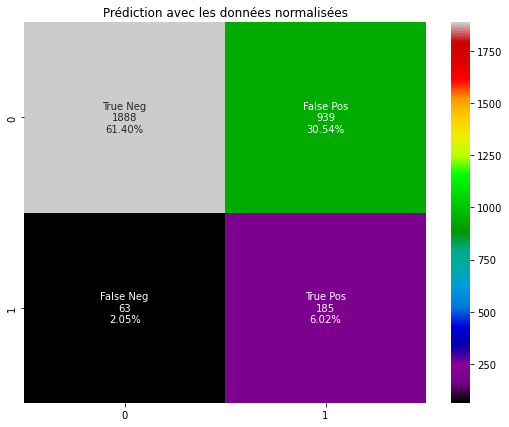

In [72]:
plot_confusion_matrix(cf_matrix)

Deuxièmment, On regarde confusion matrix de LGBMClassifier

In [179]:
model = df_scores_GS.iloc[0, 3]
print(model)
model.fit(X1_train, y1_train)
y_pred = model.predict(X1_test)
cf_matrix = confusion_matrix(y1_test, y_pred)

Pipeline(steps=[('step1',
                 RandomUnderSampler(random_state=42,
                                    sampling_strategy='majority')),
                ('classifier',
                 LGBMClassifier(max_depth=5, n_estimators=45,
                                random_state=42))])


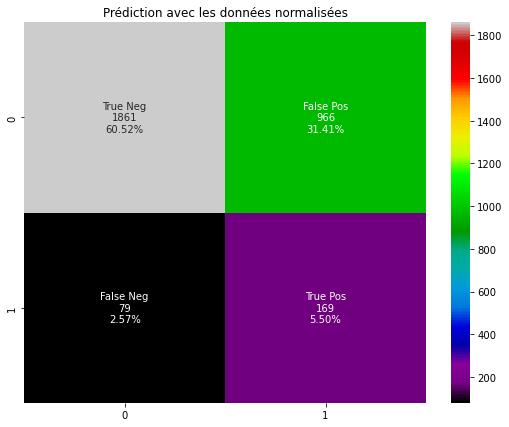

In [180]:
plot_confusion_matrix(cf_matrix)

On s'intéresse False Negative values, donc FN values de XGBOOST (63) est moins que LGBMClassifier (75)

### SHAP (FEATURE IMPORTANCEs) pour comprendre l'effet des features

In [168]:
# compute SHAP values
%time 
clf = model[1]
shap_values = shap.TreeExplainer(clf).shap_values(X1_test)

CPU times: user 5 µs, sys: 4 µs, total: 9 µs
Wall time: 11 µs


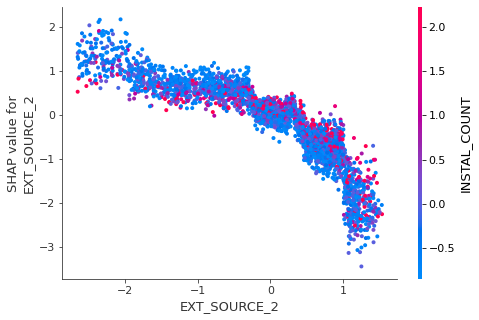

In [169]:
# On a choisi une feature comme exemple pour voir la dependence plot
shap.dependence_plot("EXT_SOURCE_2", shap_values, X1_test,feature_names=X1.columns)

L'effet des features de SHAP via summary-plot. Les rouges sur features ont grand effet sur shap_values/model

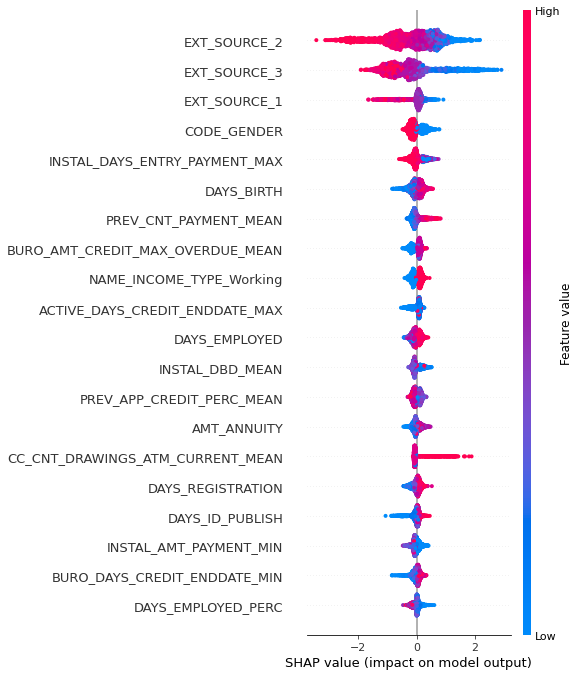

In [170]:
f3 = plt.figure()
shap.summary_plot(shap_values, features=X1_test, max_display=20, feature_names=X1.iloc[0,:].index)
f3.savefig("summary_plot3.png", bbox_inches='tight', dpi=600)

L'effet des features de SHAP via summary-plot(Bar Plot)

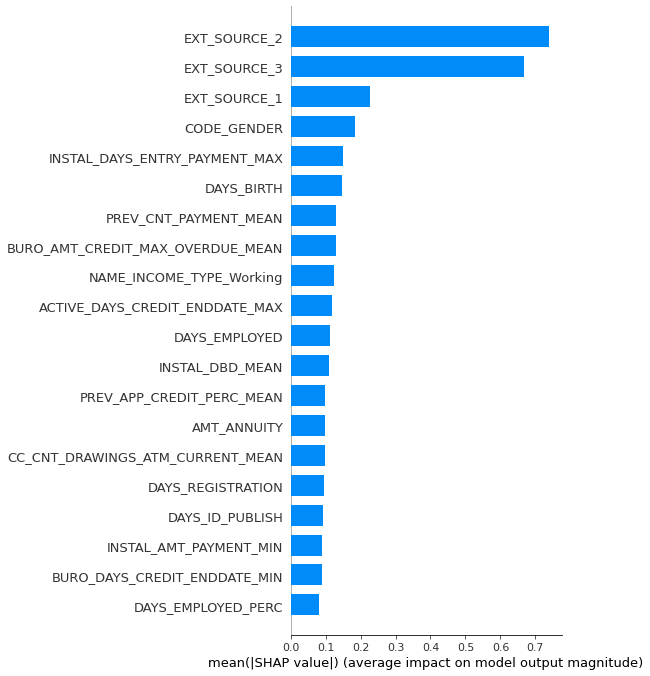

In [175]:
f4= plt.figure()
shap.summary_plot(shap_values, features=X1_test, feature_names=X1.iloc[0,:].index, plot_type='bar')
f4.savefig("summary_plot4.png", bbox_inches='tight', dpi=600)

### LOCAL Feature Importance (Par client/ Loan ID)

In [66]:
# Get the predictions and put them with the test data.

X_test_output = X1_test_new.copy()
X_test_output.shape 

(3075, 795)

In [67]:
shap.initjs()

def shap_plot_force(j):
    '''Tracer le clients features via force plot'''
    explainerModel = shap.TreeExplainer(clf)
    shap_values_Model = explainerModel.shap_values(X_test_output)
    print("Model Prédiction probabilité : ", clf.predict_proba(X_test_output)[:,1][j])
    print('\n')
    p = shap.force_plot(explainerModel.expected_value, shap_values_Model[j], feature_names=X1.iloc[j,:].index)
    return(p)

def shap_plot_waterfall(j):
    '''Tracer le clients features via waterfall plot'''
    explainerModel = shap.TreeExplainer(clf,X_test_output)
    shap_values_Model = explainerModel(X_test_output)
    print("Model Prédiction probabilité : ", clf.predict_proba(X_test_output)[:,1][j])
    print('\n')
    p = shap.waterfall_plot(shap_values_Model[j])
    return(p)

In [68]:
shap_plot_force(2345)

Model Prédiction probabilité :  0.48556188




Model Prédiction probabilité :  0.48556188




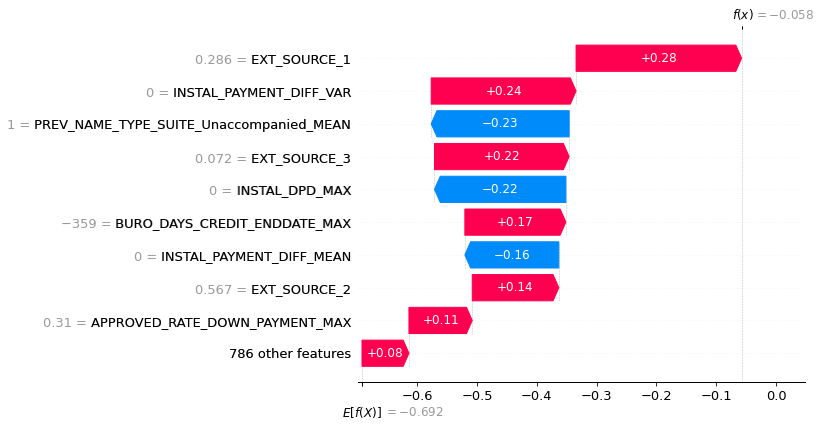

In [69]:
shap_plot_waterfall(2345)

### ROC et Precision/Recall courbes sur reduced data

In [73]:
# Function to plot ROC and Precision-Recall curves
def ROC_PR_curves(test_labels, list_pred_proba, models_name):
    '''Function to plot ROC and PR curves
    test_labels --> True labels to predicts, y_test for example 1_D
    list_pred_proba --> models predicts probalbility 1-D
    models_name --> list of models names in the same order than list_predict_proba'''
    # figure init
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,7))
    plt.suptitle('ROC / PR curves for our models (validation data)', fontweight='bold')
    ax1.plot([0,1], [0,1], 'k--')
    ax2.plot([0,1], [0,0], 'k--')
    ax1.set_title('ROC')
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax2.set_title('Precision / Recall')
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    # counter for getting models names
    count=0
    for pred_prob in list_pred_proba:
        # fpr and tpr calcul
        fpr, tpr, _ = roc_curve(test_labels, pred_prob)
        # Precision and recall calcul
        pr, rec, _ = precision_recall_curve(test_labels, pred_prob)
        # Plot ROC curve
        ax1.plot(fpr, tpr, label=f'{models_name[count]} / AUC={roc_auc_score(test_labels, pred_prob):.3f}')
        # Plot PR curve
        ax2.plot(rec, pr, label=models_name[count])
        count+=1
    ax1.legend()
    # ax2.legend() optionnal
    plt.show()

### ROC-PR Pour SMOTE

In [74]:
y_pred_new_list_SMOTE = [i[0] for i in y_pred_prob_list if i[1] == 'SMOTE(random_state=42) train data']

y_pred_new_list_SMOTE

[array([0.07441612, 0.06768876, 0.05673964, ..., 0.09167831, 0.10913106,
        0.15545086]),
 array([0.06095033, 0.04507391, 0.03796701, ..., 0.03767725, 0.04326991,
        0.09914296], dtype=float32),
 array([0.10063759, 0.34895867, 0.16498648, ..., 0.16441501, 0.03034456,
        0.6649848 ]),
 array([0.25027546, 0.30308388, 0.11765276, ..., 0.19096663, 0.19688402,
        0.44297894]),
 array([0.14367816, 0.14367816, 0.19683656, ..., 0.14367816, 0.02734375,
        0.61386139]),
 array([0.83695652, 0.83695652, 0.67934783, ..., 0.92934783, 0.84782609,
        0.86956522])]

                  model  F1_score  Precision    Recall  Accuracy   ROC_AUC  fbeta_Score  Train Time(s)  Predict Time(s)                            Comment
4        LGBMClassifier  0.067416   0.473684  0.036290  0.919024  0.722415     0.044510       4.053316         0.013925  SMOTE(random_state=42) train data
5               XGBoost  0.030769   0.333333  0.016129  0.918049  0.715145     0.019920      23.052927         0.027315  SMOTE(random_state=42) train data
9   Logistic Regression  0.244782   0.160050  0.520161  0.741138  0.692741     0.358732       1.941969         0.002532  SMOTE(random_state=42) train data
10        Random Forest  0.055556   0.200000  0.032258  0.911545  0.642765     0.038760       5.901054         0.043563  SMOTE(random_state=42) train data
13        Decision Tree  0.093750   0.105000  0.084677  0.867967  0.608149     0.088087       3.769756         0.008009  SMOTE(random_state=42) train data
14  K-Nearest Neighbors  0.149538   0.080946  0.979839  0.101138  0.56

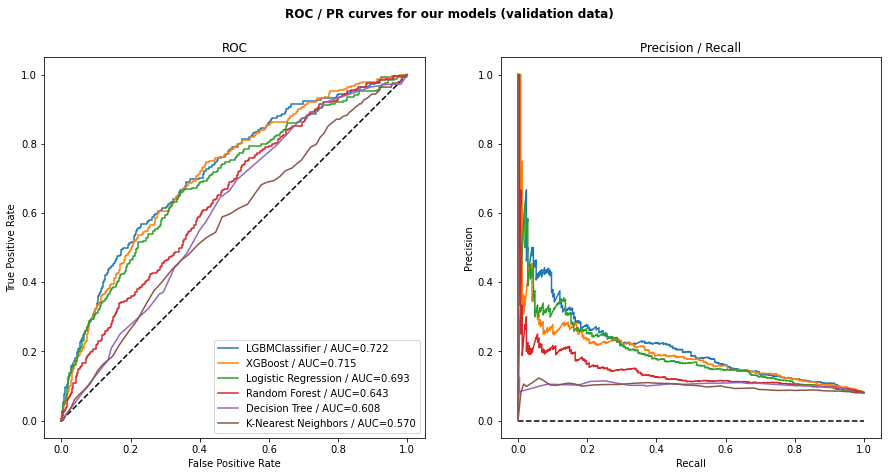

In [75]:
df_SMOTE = df_scores_avec_GS[(df_scores_avec_GS['Comment'] == 'SMOTE(random_state=42) train data')]
print(df_SMOTE)
ROC_PR_curves(y1_test, y_pred_new_list_SMOTE, df_SMOTE['model'].tolist())

### ROC-PR Pour RUS

In [76]:
y_pred_new_list_RUS = [i[0] for i in y_pred_prob_list if i[1] == "RandomUnderSampler(random_state=42, sampling_strategy='majority') train data"]

y_pred_new_list_RUS

[array([0.21224332, 0.43890859, 0.29647005, ..., 0.40771801, 0.52965617,
        0.7545461 ]),
 array([0.19892897, 0.24251984, 0.2046759 , ..., 0.56411624, 0.44196123,
        0.7302568 ], dtype=float32),
 array([0.39305309, 0.54130722, 0.37144785, ..., 0.44924793, 0.48189954,
        0.55259528]),
 array([0.15081675, 0.5259434 , 0.49198882, ..., 0.25591011, 0.5460545 ,
        0.77906561]),
 array([0.44949495, 0.45454545, 0.42424242, ..., 0.46969697, 0.46464646,
        0.50505051]),
 array([0.47222222, 0.25757576, 0.5603272 , ..., 0.25757576, 0.25757576,
        0.80128205])]

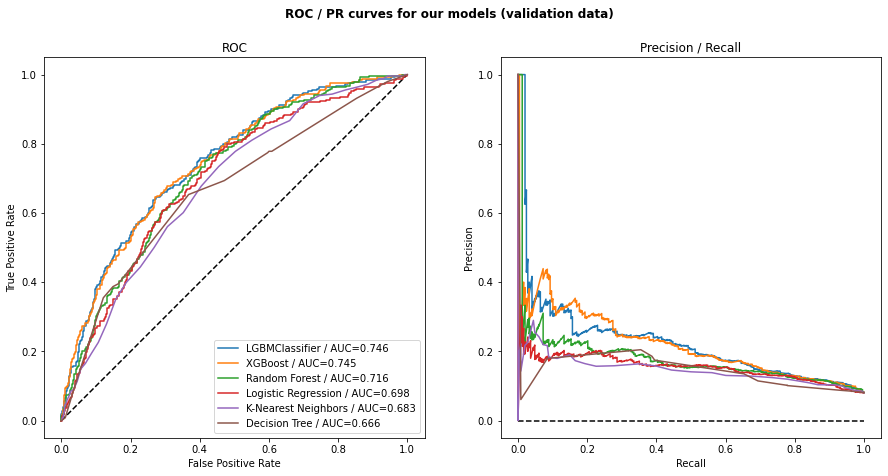

In [77]:
df_RUS = df_scores_avec_GS.loc[(df_scores_avec_GS['Comment'] == "RandomUnderSampler(random_state=42, sampling_strategy='majority') train data")]

ROC_PR_curves(y1_test, y_pred_new_list_RUS, df_RUS['model'].tolist())

### Compare les models par rapport aux scores

In [78]:
df_barg = df_scores_total.set_index('model').sort_values(by = 'fbeta_Score', ascending = False)
df_barg

,F1_score,Precision,Recall,Accuracy,ROC_AUC,fbeta_Score,Train Time(s),Predict Time(s),Comment
model,,,,,,,,,
XGBoost,0.253991,0.154867,0.705645,0.665691,0.753579,0.412347,3.767975,0.019523,"RandomUnderSampler(random_state=42, sampling_strategy='majority') train data"
XGBoost,0.252015,0.153984,0.693548,0.667967,0.745001,0.407776,1.403097,0.019553,"RandomUnderSampler(random_state=42, sampling_strategy='majority') train data"
LGBMClassifier,0.244396,0.148899,0.681452,0.660163,0.745953,0.397273,0.637016,0.062132,"RandomUnderSampler(random_state=42, sampling_strategy='majority') train data"
LGBMClassifier,0.239880,0.147330,0.645161,0.670244,0.727360,0.384986,0.513429,0.015790,"RandomUnderSampler(random_state=42, sampling_strategy='majority') train data"
Random Forest,0.236591,0.144654,0.649194,0.662114,0.709048,0.382423,0.398019,0.049748,"RandomUnderSampler(random_state=42, sampling_strategy='majority') train data"
Random Forest,0.237846,0.146006,0.641129,0.668618,0.715535,0.382028,0.294798,0.034828,"RandomUnderSampler(random_state=42, sampling_strategy='majority') train data"
Logistic Regression,0.228856,0.138913,0.649194,0.647154,0.698175,0.374245,0.078026,0.003639,"RandomUnderSampler(random_state=42, sampling_strategy='majority') train data"
Logistic Regression,0.228856,0.138913,0.649194,0.647154,0.698175,0.374245,0.100953,0.002738,"RandomUnderSampler(random_state=42, sampling_strategy='majority') train data"
Decision Tree,0.223602,0.134888,0.653226,0.634146,0.665773,0.369357,0.222661,0.007045,"RandomUnderSampler(random_state=42, sampling_strategy='majority') train data"


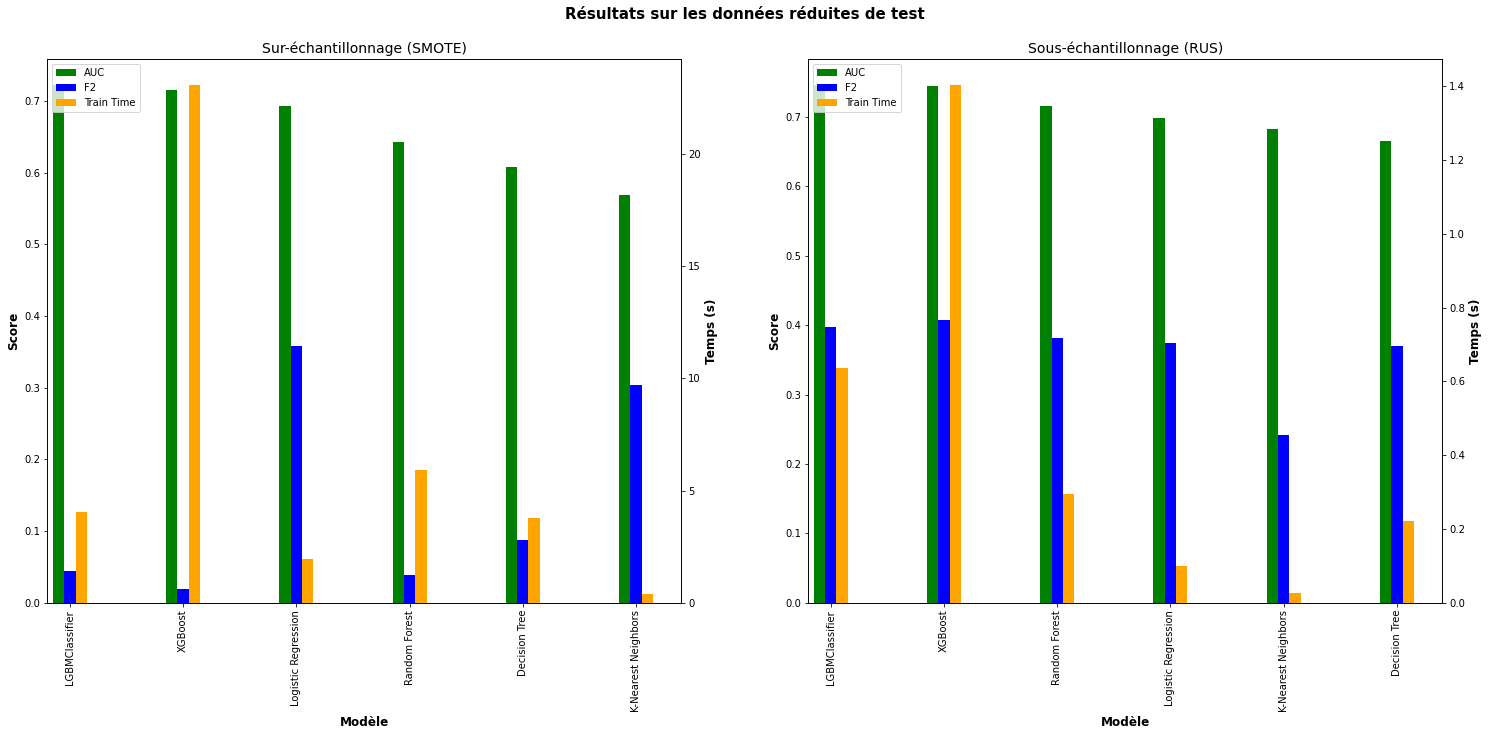

In [80]:
figure_bargraph = plt.figure(figsize=(25,10))
plt.axis('off')
plt.title('Résultats sur les données réduites de test', fontweight='bold', fontsize=15, pad=40)
ax = figure_bargraph.add_subplot(121) # Create matplotlib axes
ax2 = ax.twinx()
width = 0.10
plt.title('Sur-échantillonnage (SMOTE)', fontsize=14)
df_barg = df_scores_avec_GS.set_index('model')
df_barg = df_barg.loc[(df_barg['Comment'] == 'SMOTE(random_state=42) train data')]
df_barg['ROC_AUC'].plot(kind='bar',color='green', ax=ax, width=width, position=1.5)
df_barg['fbeta_Score'].plot(kind='bar',color='blue', ax=ax, width=width, position=0.5)
df_barg['Train Time(s)'].plot(kind='bar',color='orange', ax=ax2, width=width, position=-0.5)
h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax.legend(h1+h2, ['AUC', 'F2', 'Train Time'], loc=2)
ax.set_xlabel('Modèle', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax2.set_ylabel('Temps (s)', fontsize=12, fontweight='bold')
ax = figure_bargraph.add_subplot(122) # Create matplotlib axes
ax2 = ax.twinx()
width = 0.10
plt.title('Sous-échantillonnage (RUS)', fontsize=14)
df_barg = df_scores_avec_GS.set_index('model')
df_barg = df_barg.loc[(df_barg['Comment'] == "RandomUnderSampler(random_state=42, sampling_strategy='majority') train data")]
df_barg['ROC_AUC'].plot(kind='bar',color='green', ax=ax, width=width, position=1.5)
df_barg['fbeta_Score'].plot(kind='bar',color='blue', ax=ax, width=width, position=0.5)
df_barg['Train Time(s)'].plot(kind='bar',color='orange', ax=ax2, width=width, position=-0.5)
h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax.legend(h1+h2, ['AUC', 'F2', 'Train Time'], loc=2)
ax.set_xlabel('Modèle', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax2.set_ylabel('Temps (s)', fontsize=12, fontweight='bold')
plt.show()

### MODEL SAVE

In [151]:
model = fine_tuning_info.iloc[0,3]
model

Pipeline(steps=[('step1',
                 RandomUnderSampler(random_state=42,
                                    sampling_strategy='majority')),
                ('classifier',
                 XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               gamma=0, gpu_id=-1, grow_policy='depthwise',
                               importance_type=None, interaction_constraints='',
                               learning_rate=0.2, max_bin=256,
                               max_cat_to_onehot=4, max_delta_step=0,
                               max_depth=10, max_leaves=0, min_child_weight=1,
                               missing=nan, monotone_constraints='()',
                               n_estimators=115, n_jobs=0, num_parallel_tree=1,
                               predictor='auto', random_state=42, reg_alpha=0,
                               reg_lambda=1, ...))])

In [152]:
proba = model.predict_proba(test_sample.values)[:,1]
proba

array([0.1628052 , 0.36491743, 0.07088859, ..., 0.254496  , 0.10385884,
       0.9489253 ], dtype=float32)

In [157]:
# save to JSON
model[1].save_model("pipeline_housing.json")

In [159]:
model = xgb.XGBClassifier()
model.load_model("pipeline_housing.json")

In [161]:
pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.
